In [1]:
# This is the code associated with template banks for higher modes
# as given in arXiv:2310.15233

# Section 1 deals with making the template banks

# Section 2 show how to use the saved template banks to generate waveforms

# Section 3 deals with checking effectualness of the template banks

# Please email Jay (jayw@ias.edu) if there are any issues

# Check the google drive folder for the latest version of this and other notebooks:
# https://drive.google.com/drive/folders/15avuKxY40aX9Ru_6xkacM1ZdaGL7OgQm?usp=sharing

In [ ]:
# The code is deliberately provided in the form of a jupyter notebook
# so that the user can test various hyperparameters related to the
# template banks and tailor the code to suit their needs.
# Also, the intermediate plots can help in understanding the code better
# and provide intermediate checks for the banks.

In [1]:
import os, sys
from pathlib import Path
sys.path.insert(0,os.path.join(Path(os.getcwd()).parent, 'Pipeline'))
sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias") # personalize path if needed
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
from numpy import amin,amax
import template_bank_generator_HM as tg
import template_bank_params_O3a_HM as tbp # same used for O3a and O3b
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy, copy
from scipy import interpolate
from importlib import reload
import json, glob, time
import params, utils, joblib

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal,lalsimulation
lal.swig_redirect_standard_output_error(False);

import multiprocess as mp
import tqdm.notebook as tqdm

In [2]:
# Setting matplotlib params for aesthetic plots
#%matplotlib widget
# %matplotlib inline
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["axes.grid"]=True;plt.rcParams["grid.alpha"]=0.4; 
plt.rcParams["grid.color"]='#999999'; plt.rcParams["grid.linestyle"]='--'

In [3]:
# Directory for storing plots
plotdir = '/data/jayw/CCA/Plots/'
plot_data_dir = '/data/jayw/IAS/GW/Data/PlotsPaper/'
trashdir = '/data/jayw/IAS/GW/Trash/Delete/'

In [4]:
# Initialize a random parameter dictionary to get started
par_dic = {
    'd_luminosity': 1.0,
    'f_ref': 50.0,
    'iota': 1.0,
    'l1': 0.0,
    'l2': 0.0,
    'm1': 50,
    'm2': 3.4,
    's1x': 0.000,
    's1y': 0.0,
    's1z': -0.24,
    's2x': 0.000,
    's2y': 0.0,
    's2z': -0.2,
    'phi_ref': 0.0}

def _get_s1z(chieff, q, s2z):
    return (1+q)*chieff - q*s2z

def _s1z_lim(chieff, q):
    s1z_min = np.maximum(_get_s1z(chieff, q, s2z=1), -1)
    s1z_max = np.minimum(_get_s1z(chieff, q, s2z=-1), 1)
    return s1z_min, s1z_max

def par_transform(M,lnq,chieff,cumchidiff):    
    
    _=np.zeros((len(M),6))
    
    q=np.exp(lnq)
    _[:,0]=M/(1+q); _[:,1]=M*q/(1+q)
    
    s1z_min, s1z_max = _s1z_lim(chieff, q)
    s1z = s1z_min + cumchidiff * (s1z_max - s1z_min)
    _[:,3] = ((1+q)*chieff - s1z) / q; _[:,2]=s1z
    
    return _

def inverse_transform(arr):
        """(s1z, s2z) to (chieff, cumchidiff)."""
        [m1, m2 , s1z, s2z] = arr
        q = m2 / m1
        chieff = (s1z + q*s2z) / (1 + q)
        s1z_min, s1z_max = _s1z_lim(chieff, q)
        cumchidiff = (s1z - s1z_min) / (s1z_max - s1z_min)
        return [chieff,cumchidiff]

In [5]:
# Set the number of cores 
ncores = 10 # mp.cpu_count() if needed

# 1. Make template bank from scratch

In [4]:
# This section is for generating the data used to make the template bank for higher modes

In [6]:
# Change DATA_ROOT in utils.py to where you want your data and
# template banks to be stored

utils.DATA_ROOT

'/Users/jayw/Documents/Acad/GW/Pipeline_data'

In [7]:
# The banks and the waveforms to make the banks will be created at the following paths
# given in template_bank_params_O3a_HM.py
tbp.DIR, tbp.wf_DIR
# Either create these directories or modify the paths in the .py file

# os.makedirs(tbp.DIR, exist_ok=True)
# os.chmod(tbp.DIR, 0o777)

('/Users/jayw/Documents/Acad/GW/Pipeline_data/templates/O3_hm/Multibanks',
 '/Users/jayw/Documents/Acad/GW/Pipeline_data/templates/O3_hm/wf_reservoir')

## Define minimal freq-bins

### Generating reference PSD by looking at some strain files from O3a (skip this)

In [ ]:
# GW strain data files are needed for running this sub-section

# ASD file has already been saved for O3a in the small_data/ folder,
#  so no need of running this sub-section (unless you want to remake the file)

In [16]:
# Triggerlist filenames, we'll get asdfuncs from them
fnames = [f for f in glob.glob('/data/bzackay/GW/O3Events/*/*.json')
          if ('H1' in f or 'L1' in f) and not 'GW190425' in f]

In [ ]:
n_files = min(200, len(fnames))
f_full = np.geomspace(10, 1e3, 1000)  # [Hz]
percentile = 10

import triggers_single_detector
asds = np.array([triggers_single_detector.TriggerList.from_json(fname).asdfunc(f_full)
                 for fname in np.random.choice(fnames, n_files, replace=False)])
median_asd = np.percentile(asds, percentile,  axis=0)

In [ ]:
# if not os.path.isfile(tbp.asd_filepath):
#     np.save(tbp.asd_filepath, np.c_[f_full, median_asd])
# else:
#     print(f"File {tbp.asd_filepath!r} exists, didn't overwrite.")

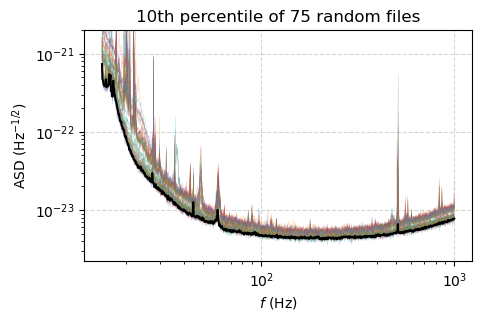

In [276]:
plt.figure(figsize=(5,3))
plt.loglog(f_full, asds.T, lw=.2, alpha=.5)
plt.loglog(f_full, median_asd, 'k', lw=1.5)
plt.title(f'{percentile}th percentile of {n_files} random files')
plt.xlabel(r'$f$ (Hz)')
plt.ylabel(r'ASD (Hz$^{-1/2}$)')
plt.ylim(top=2e-21);

### Generate freq-bins for amplitudes

In [8]:
# We need a not too large frequency array to generate waveforms so that the waveform computation is not too slow
# An optimal frequency array is such that the expected SNR of the waveform in each frequency bin is similar
# We generate such freq array considering a simple amplitude A(f) \propto f^{-7/6} and a reference ASD

In [8]:
# Loading the 
# This does a more robust form of np.interp
tg.DEFAULT_ASDF = utils.asdf_fromfile(tbp.asd_filepath)

In [9]:
# Measure for cosines of amplitudes

asd_data = np.load(tbp.asd_filepath)
f_full = asd_data[0]
psd = asd_data[1]**2
df = tg.get_df(f_full)

overlap_measure = 4 * df / psd
Aref = (f_full/100)**(-7/6) # later used for normalizing the waveforms by a power law

measure = overlap_measure * (Aref**2)
cum_measure = np.cumsum(measure)
measure = measure/cum_measure[-1]
cum_measure = cum_measure/cum_measure[-1]

_ = (cum_measure>0) # Finding first element with non-zero cum_measure (for interpolation to not break)
ind = 0
for i in range(len(_)):
    if (_[i]==True): ind=i-1; break

fsInterpolate = interpolate.InterpolatedUnivariateSpline(cum_measure[ind:],f_full[ind:])

# Choose bins of frequencies with equal measure in them
# (f_amp gives such frequencies to interpolate the amplitudes)
f_amp = fsInterpolate(np.linspace(0.0001,1,2000)) 
Aref = (f_amp/100)**(-7/6)

psd = tg.DEFAULT_ASDF(f_amp)**2
df = tg.get_df(f_amp)
weights = 4 * df / psd * Aref**2 
weights=weights/np.sum(weights)

# Note that weights are approximately 1/2000

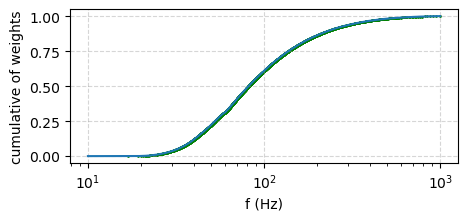

In [10]:
plt.figure(figsize=(5,2))
plt.plot(f_full,cum_measure)
plt.scatter(f_amp,np.cumsum(weights),s=1,c='g')
plt.xlabel('f (Hz)'); plt.ylabel('cumulative of weights')
plt.xscale('log')

## Generate input waveforms & split banks by amplitude

**Generate parameters**

In [11]:
# Creating samples of input parameters with appropriate priors
# Load using the following or uncomment the code below:
# We use quite broad priors for generating the template banks
# so that the template bank has coverage over a large region of parameter space
# Note that these priors are different from the astrophysical
# prior that we use to rank triggers caught by different templates
# (see notebook #2.Astrophysical_prior.ipynb for details)

input_pars = np.load(os.path.join(tbp.wf_DIR,'pars_samples.npy'))
# input_pars has n_samples x [m1_det, m2_det, s1z, s2z]
Mrandom = input_pars[:,0] + input_pars[:,1]
lnqrandom = np.log(input_pars[:,1]/input_pars[:,0])
[chieffrandom , cumchidiffrandom] = inverse_transform(input_pars[:,:4].T)

# Deriving Mchirp
_=np.exp(lnqrandom)
_=_/(1+_)**2
Mchrandom=Mrandom*_**(3/5)

In [12]:
# ## Uncomment to make pars_samples.py 

# nwf=100000
# alpha=1/3

# lnqrandom=np.random.uniform(np.log(1/18),np.log(0.99),3*nwf)
# chieffrandom=np.random.uniform(-0.95,0.95,3*nwf)
# cumchidiffrandom=np.random.uniform(0,1,3*nwf)

# ## Put similar number in each bank

# Mrandom=np.random.uniform(6**(1-alpha),400**(1-alpha),nwf)
# Mrandom=Mrandom**(1/(1-alpha))

# ## Add so I have better distribution in phase scale

# _=np.random.uniform(np.log(6),np.log(400),nwf)
# _=np.exp(_)
# Mrandom=np.append(Mrandom,_)

# ## Add some more at low mchirp

# Mchrandom=np.random.uniform(2.5,30,nwf)
# _=np.exp(lnqrandom[2*nwf:])
# _=_/(1+_)**2
# _=Mchrandom/_**(3/5)
# Mrandom=np.append(Mrandom,_)

# input_pars = par_transform(Mrandom,lnqrandom,chieffrandom,cumchidiffrandom)

# ## Only including black holes (not neutron stars)
# mask=input_pars[:,1]>3 
# input_pars=input_pars[mask]
# np.save(os.path.join(tbp.wf_DIR,'pars_samples.npy'), input_pars)

**Generate amplitudes:**

In [10]:
# This cell is used for generating the amplitudes
# not needed if you want to load the amplitudes from the cell below

def amps_HM(fs , p , hm=True):
    par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
    
    if hm is False:
        amp = np.abs(tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXAS', [(2, 2)])[0])
        
    else:
        amp = np.zeros((3,len(fs)))
        amp[0] = np.abs(tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXAS', [(2, 2)])[0])
        amp[1] = np.abs(tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXHM', [(3, 3), (3, -3)])[0])
        amp[2] = np.abs(tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXHM', [(4, 4), (4, -4)])[0])
        # need to specify (l,-m) modes for XHM explicitly as they aren't included by default
        
    return(amp)

In [11]:
# Skip this cell if kmeans.pkl and bank_ids.npy were already saved
# Otherwise, generate or load amps_samples

# ## Code to generate the above samples (takes about 15-30 mins)
# with mp.Pool(ncores) as p:
#         amps_samples = np.abs(p.starmap(amps_HM,
#                            ((f_amp, pars) for pars in input_pars)))

# ## The loaded ampiltudes are already normalized by f^{-7/6} using the following code

# amps_samples /= Aref
# norm = np.sum(weights*amps_samples**2,axis=-1)**0.5
# for i in range(len(amps_samples)):
#     amps_samples[i] = (amps_samples[i].T/norm[i]).T

# No real need to save the amps_samples as one does not need to load them once the
# kmeans and bank_ids are generated, amps_samples are not saved in our template banks
# np.save(os.path.join(tbp.wf_DIR,'amps_samples.npy'), amps_samples)

# amps_samples = np.load(os.path.join(tbp.wf_DIR,'amps_samples.npy'))

In [12]:
# %%time

# The number of banks is decided by how good do you want the amplitude overlap to be
# in the plots below
# Note that a larger number of banks will lead to more computation needed
# later in the data pre-processing step of the pipeline
nbanks = 17
# Add this number to tbp.nbanks once finalized

# Splitting the banks using K-Means clustering algorithm on amplitudes of samples
# either generate the kmeans when running for the first time or load it from the saved file

import pickle

with open(os.path.join(tbp.wf_DIR,'kmeans.pkl'), 'rb') as f:
    kmeans = pickle.load(f)

# Uncomment when running for the first time
# kmeans = KMeans(n_clusters=nbanks, random_state=0).fit(amps_samples[:,0]) # Time intensive
# pickle.dump(kmeans, open(os.path.join(tbp.wf_DIR,'kmeans.pkl'), 'wb')) # saving

In [13]:
Af_kmeans_22 = np.asarray([x/np.sum(x**2*weights)**0.5 for x in kmeans.cluster_centers_])
Af_kmeans_cumsum = np.cumsum(Af_kmeans_22**2*weights,axis=1)

# Order the banks by cumulative SNR in the 22 mean amplitude
order = np.argsort(np.argmin((Af_kmeans_cumsum-0.97)**2,axis=1))[::-1]
Af_kmeans_22 = Af_kmeans_22[order]

In [14]:
# Either load the bank_ids or generate the bank_ids (when running for the first time)
bank_ids = np.load(os.path.join(tbp.wf_DIR,'bank_ids.npy'))

# Uncomment when running for the first time
# bank_ids = kmeans.predict(amps_samples[:,0])
# bank_ids = np.asarray([np.where(order == b)[0][0] for b in bank_ids])
# np.save(os.path.join(tbp.wf_DIR,'bank_ids.npy'), bank_ids)

In [35]:
# Optional code: Given a set of pars, one could find the bank_id using the following code
# TODO: later make this a module in template_bank_generator_HM.py

# pars = [73, 37, -0.03,  -0.21] # [m1, m2, chi1z, chi2z]
# amps_sample =amps_HM(f_amp, pars, hm=False)/Aref
# norm = np.sum(weights*amps_sample**2,axis=-1)**0.5
# np.where(order==kmeans.predict([amps_sample/norm]))

(array([7]),)

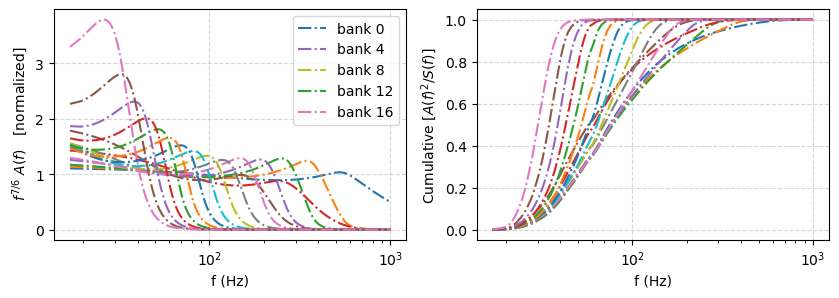

In [15]:
plt.figure(figsize=(10,3))

plt.subplot(121)
for ib, Af in enumerate(Af_kmeans_22):
    if ib%4==0:
        plt.plot(f_amp,Af,'-.', label=f'bank {ib}')
    else:
        plt.plot(f_amp,Af,'-.')
plt.xlabel('f (Hz)'); plt.ylabel(r' $f^{7/6}\ A(f) $   [normalized]')
plt.xscale('log')
plt.legend()

Af_kmeans_cumsum=np.cumsum(Af_kmeans_22**2*weights,axis=1)
plt.subplot(122)
for Af in Af_kmeans_cumsum:
    plt.plot(f_amp,Af,'-.')
plt.xlabel('f (Hz)'); plt.ylabel('Cumulative [$ A(f)^2/S(f) $]')
plt.xscale('log')

In [35]:
best_overlap_kmeans = np.einsum('ij,kj,j', Af_kmeans_22, amps_samples[:,0], weights)
best_overlap_kmeans = np.max(best_overlap_kmeans,axis=0)

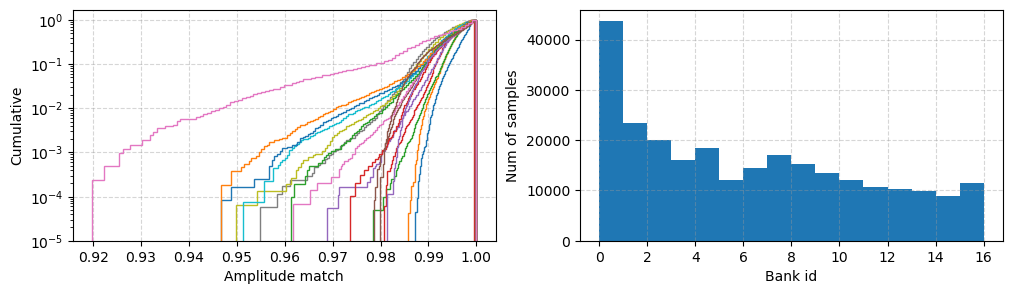

In [36]:
# Cosines for waveform amplitudes with Af_kmeans for the 22 mode

plt.figure(figsize=(12,3))
plt.subplot(121)
for ib in range(nbanks):
    plt.hist(best_overlap_kmeans[bank_ids==ib],bins=100,histtype='step',density=True, cumulative=True);
plt.yscale('log'); plt.xlabel('Amplitude match'); plt.ylabel('Cumulative'); plt.ylim(bottom=1e-5);

plt.subplot(122)
plt.hist(bank_ids,bins=np.linspace(0,16,17));
plt.xlabel('Bank id'); plt.ylabel('Num of samples');

# There is a correction for Bank 16 amplitudes based on SVDs and random forest which will be introduced later
# Generally, if you lower the number of banks, the overlaps degrade

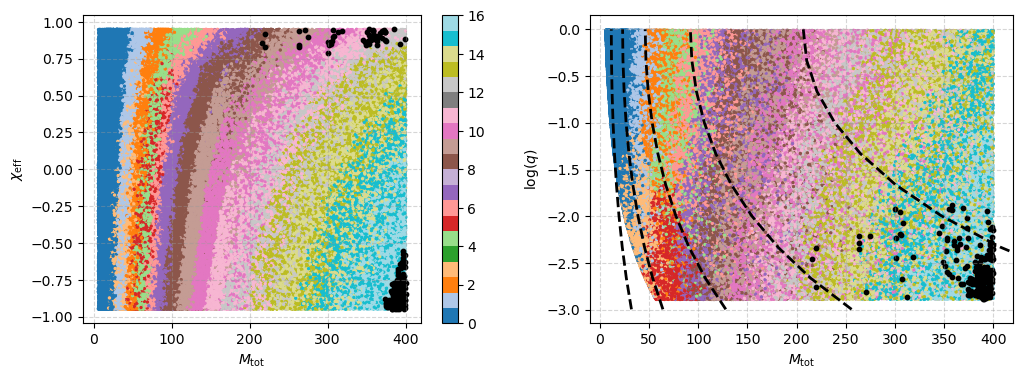

In [38]:
# Colors represent various banks, black dashed are lines of constant chirp mass,
#  black dots are points with overlap<0.96

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(Mrandom,chieffrandom,c=bank_ids,s=2,cmap='tab20'); plt.colorbar()
bad = best_overlap_kmeans < 0.96
plt.scatter(Mrandom[bad],chieffrandom[bad],s=10,c='k');
plt.xlabel(r'$M_\mathrm{tot}$'); plt.ylabel(r'$\chi_\mathrm{eff}$')
plt.subplot(122)
plt.scatter(Mrandom,lnqrandom,c=bank_ids,s=2,cmap='tab20');
plt.scatter(Mrandom[bad],lnqrandom[bad],c='k',s=10)
plt.xlabel(r'$M_\mathrm{tot}$'); plt.ylabel(r'log($q$)')

# Overplotting in dashed-black constant chirp mass contours
#  for dividing banks from Roulet et al. 19 (just for reference)
lnq=np.linspace(np.log(0.05),0,10)
q=np.exp(lnq)
eta=q/(1+q)**2
plt.plot((5/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((10/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((20/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((40/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((90/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.xlim(-10,420);

In [39]:
# Generating mean amplitudes for higher modes

Af_kmeans_33 = Af_kmeans_22.copy(); Af_kmeans_44 = Af_kmeans_22.copy()

for i in range(len(Af_kmeans_22)):
    mask = bank_ids==i
    Af_kmeans_33[i] = np.mean(amps_samples[:,1,:][mask] , axis=0)
    Af_kmeans_33[i] /= np.sum(Af_kmeans_33[i]**2*weights)**0.5
    
    Af_kmeans_44[i] = np.mean(amps_samples[:,2,:][mask] , axis=0)
    Af_kmeans_44[i] /= np.sum(Af_kmeans_44[i]**2*weights)**0.5

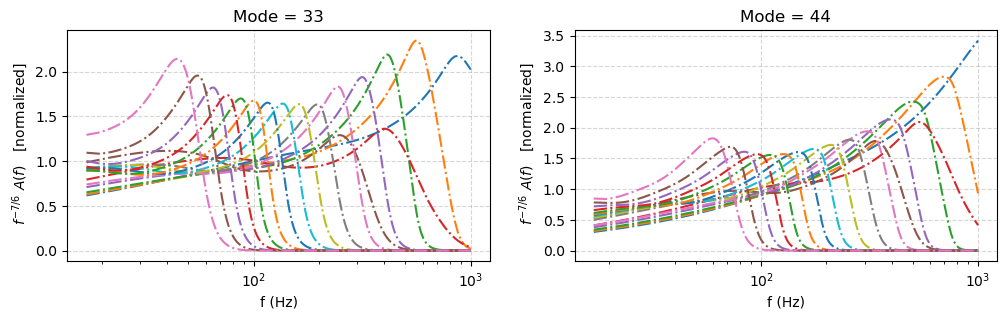

In [41]:
plt.figure(figsize=(12,3))

plt.subplot(121)
for Af in Af_kmeans_33:
    plt.plot(f_amp,Af,'-.')
plt.xlabel(r'f (Hz)'); plt.ylabel(r' $f^{-7/6}\ A(f) $   [normalized]')
plt.xscale('log'); plt.title('Mode = 33')

plt.subplot(122)
for Af in Af_kmeans_44:
    plt.plot(f_amp,Af,'-.')
plt.xlabel(r'f (Hz)'); plt.ylabel(r' $f^{-7/6}\ A(f) $   [normalized]')
plt.xscale('log'); plt.title('Mode = 44');

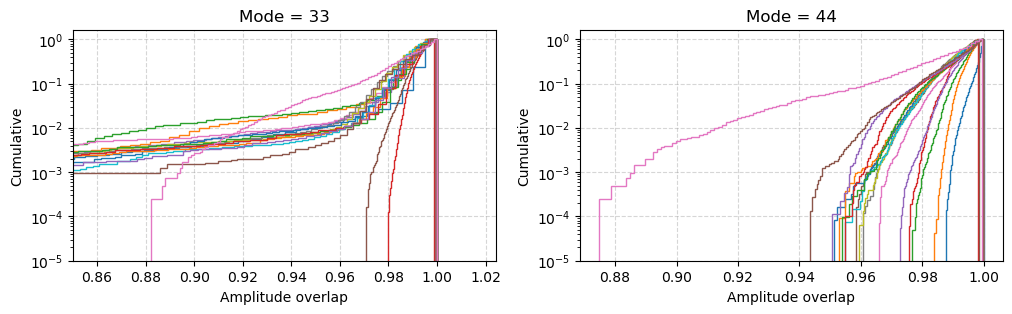

In [42]:
# Overlaps for waveform amplitudes with Af_kmeans for the higher modes

# best_overlap_kmeans=np.array([])
# for i in range(nbanks):
#     best_overlap_kmeans=np.append(best_overlap_kmeans,
#           (np.sum(Af_kmeans_33[i]*amps_samples[:,1][bank_ids==i]*weights, axis=1)))

plt.figure(figsize=(12,3))
plt.subplot(121)
for i in range(nbanks):
    plt.hist(np.sum(Af_kmeans_33[i]*amps_samples[:,1][bank_ids==i]*weights, axis=-1),
             bins=100,histtype='step', density=True, cumulative=True);
plt.yscale('log'); plt.xlabel('Amplitude overlap'); plt.ylabel('Cumulative'); 
plt.title('Mode = 33'); plt.ylim(bottom=1e-5);plt.xlim(left=0.85)

# best_overlap_kmeans=np.array([])
# for i in range(nbanks):
#     best_overlap_kmeans=np.append(best_overlap_kmeans,())

plt.subplot(122)
for i in range(nbanks):
    plt.hist(np.sum(Af_kmeans_44[i]*amps_samples[:,2][bank_ids==i]*weights, axis=-1),
             bins=100,histtype='step', density=True, cumulative=True);
plt.yscale('log'); plt.xlabel('Amplitude overlap'); plt.ylabel('Cumulative'); 
plt.title('Mode = 44'); plt.ylim(bottom=1e-5);

# Note that using the XHM approximant gave us amplitude overlaps which are worse for HM 
# compared to 22, but keep in mind that the SNR in the HM is also lower
# and correspondingly the mismatch threshold

In [43]:
del amps_samples # saving memory, as the amplitude samples are not needed in the next section

## SVD for phases

In [16]:
def gram_schmidt_columns(X,measure):
    ws=measure**0.5
    Q, R = np.linalg.qr((X*ws).T)
    return Q.T/ws

def project_out(v,basis,measure):
    #return v - (basis @ (v*measure)) @ basis
    return v - ((v*measure) @ basis.T) @ basis

In [17]:
# Similar to previous section, we want to generate a low-dimensional frequency array to make it
# cheap to simulate waveforms. We generate a different frequency array for 
# each bank based on its amplitude A(f) that we computed in the prev section and a reference ASD
# This array is computed below as f_phases_banks

In [18]:
## Choose a different set of frequency bins for each bank

n_fs_basis = 1000 # Number of frequency bins for phase

f_phases_banks = []
f_unwrap_banks = []
basis_banks = []
weights_banks = [] # Note this is square of wts used in template_bank_generator_hm.py

for ib in range(nbanks):
    Af_bank=Af_kmeans_22[ib]
    Af_bank_interp=interpolate.InterpolatedUnivariateSpline(f_amp , Af_bank*Aref)

    mask = f_full > f_amp[0]
    fs_fine = f_full[mask]
    df = tg.get_df(fs_fine)
    psd = tg.DEFAULT_ASDF(fs_fine)**2
    measure_bank = 4 * df / psd * Af_bank_interp(fs_fine)**2
    measure_bank = measure_bank/np.sum(measure_bank)

    cum_measure_bank = np.cumsum(measure_bank)
    
    _ = (cum_measure_bank>1e-6) # Finding first element with non-zero cum_measure
    ind0=0; ind1=len(cum_measure_bank)
    for i in range(len(_)):
        if (_[i]==True and i>0): ind0=i-1; break
        
    _=(cum_measure_bank>1-1e-6) # Finding elements before cum_measure = 1
    for i in range(len(_)):
        if (_[i]==True and i<len(cum_measure_bank)): ind1=i+1; break
    fsInterpolate = interpolate.InterpolatedUnivariateSpline(cum_measure_bank[ind0:ind1],fs_fine[ind0:ind1])

    ## Choose subset of frequencies
    if ib==0: f_phase=fsInterpolate(np.linspace(0.01,0.995,n_fs_basis)) # in order to reduce the number of templates in bank 0
    else: f_phase=fsInterpolate(np.linspace(0.001,0.999,n_fs_basis))

    ## Save frequencies for unwrap
    fmax=f_phase[-1]
    fmin=f_phase[0]
    fmid=np.exp(0.5*(np.log(fmax)+np.log(fmin)))
    mchirp_ib = Mchrandom[bank_ids==ib]
    mchirp_min=np.min([np.min(mchirp_ib),20.])
    
    psd = tg.DEFAULT_ASDF(f_phase)**2
    df = tg.get_df(f_phase)
    weights_bank = 4 * df / psd * Af_bank_interp(f_phase)**2
    weights_bank /= np.sum(weights_bank) # these values should be close to 1e-3

    # generating a frequency array designed such that the unwrapping of phases is smooth
    f_unwrap_bank = tg.get_efficient_frequencies(fmin=fmin, fmid=fmid, fmax=fmax,
                              mchirp_min=mchirp_min ,delta_radians=0.5)

    vs_bank = np.asarray([np.ones(len(f_phase)),f_phase])
    basis_bank = gram_schmidt_columns(vs_bank, weights_bank)
    
    f_phases_banks.append(f_phase)
    f_unwrap_banks.append(f_unwrap_bank)
    basis_banks.append(basis_bank)
    weights_banks.append(weights_bank)

In [33]:
# Uncomment to SAVE a part of Multibank data corresponding to the banks

# for i in range(nbanks):
#     dire = os.path.join(tbp.DIR,'BBH_'+str(i))
#     if not os.path.exists(dire):
#         os.makedirs(dire)
#     np.save(os.path.join(dire,'Af.npy'),
#           np.c_[f_amp,Af_kmeans_22[i]*Aref,Af_kmeans_33[i]*Aref,Af_kmeans_44[i]*Aref])
#     np.save(os.path.join(tbp.DIR,'asd.npy'), np.load(tbp.asd_filepath))
    
#     np.save(os.path.join(dire,'f_phases.npy'),f_phases_banks[i])
#     np.save(os.path.join(dire,'f_unwrap_phases.npy'),f_unwrap_banks[i])
#     np.save(os.path.join(dire,'weights_phases.npy'),
#           np.sqrt(weights_banks[i])) # Note the sqrt

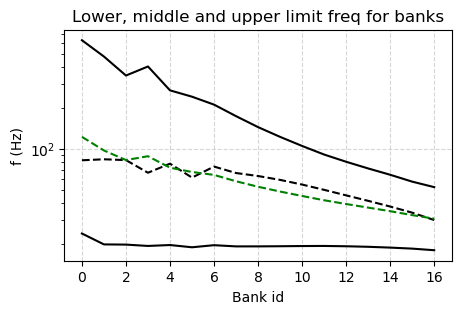

In [19]:
qaz=np.asarray(f_phases_banks)
plt.plot(range(len(Af_kmeans_22)),qaz[:,0],c='k')
plt.plot(range(len(Af_kmeans_22)),qaz[:,-1],c='k')
fmid=np.exp(np.mean(np.log(qaz),axis=1))
plt.plot(range(len(Af_kmeans_22)),fmid,'--',c='k')
fmid=np.exp(0.5*(np.log(qaz[:,0])+np.log(qaz[:,-1])))
plt.plot(range(len(Af_kmeans_22)),fmid,'--',c='g')

plt.yscale('log'); plt.xlabel('Bank id'); plt.ylabel('f (Hz)')
plt.title('Lower, middle and upper limit freq for banks');

In [20]:
# Either directly load the 22 phases or generate them with the commented out code

phases_samples = np.load(os.path.join(tbp.wf_DIR,'phases_samples.npy'))

# Uncomment when running for the first time
# def gen_phases(i):
#     bank_id=bank_ids[i]; p=input_pars[i]
#     par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
#     phases = tg.compute_hplus_hcross(f_unwrap_banks[bank_id], par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
#     phases = np.unwrap(np.angle(phases))
    
#     phases = np.interp(f_phases_banks[bank_id],f_unwrap_banks[bank_id],phases)
#     phases = project_out(phases,basis_banks[bank_id],weights_banks[bank_id])
#     return(phases)

# with mp.Pool(ncores) as p:
#         phases_samples = p.map(gen_phases,np.arange(len(bank_ids)))
# phases_samples = np.asarray(phases_samples)

# np.save(os.path.join(tbp.wf_DIR,'phases_samples.npy'),phases_samples)

## Making Sub-banks

In [21]:
# Number determined by waveform support in time-domain space
# see the code at the end of this section 'Source code for determining number of sub-bank splits'
SubBankSplits=[5,3,3,3,3,3,3,2,2,1,1,1,1,1,1,1,1]

# Once finalized, copy the following to the variable nsubbanks in template_bank_params_O3a_HM.py
# dict(zip(['BBH_'+str(i) for i in range(nbanks)] , SubBankSplits))

tbp.nsubbanks

{'BBH_0': 5,
 'BBH_1': 3,
 'BBH_2': 3,
 'BBH_3': 3,
 'BBH_4': 3,
 'BBH_5': 3,
 'BBH_6': 3,
 'BBH_7': 2,
 'BBH_8': 2,
 'BBH_9': 1,
 'BBH_10': 1,
 'BBH_11': 1,
 'BBH_12': 1,
 'BBH_13': 1,
 'BBH_14': 1,
 'BBH_15': 1,
 'BBH_16': 1}

In [23]:
## Assign samples to bins in scale within each bank

subbank_ids = np.zeros(len(bank_ids),dtype=int)
SubBank_Mchirp_bins=[]
for ib in range(nbanks):
    mask= (bank_ids==ib)
    mchirp_bank = Mchrandom[mask]
    nbins = SubBankSplits[ib]
    bn = np.quantile(mchirp_bank,np.linspace(0,1,nbins+1))
    bins = list(zip(bn[:-1],bn[1:]))
    print('Bank ... ',ib,' num subbanks:  ', len(bins))
    print(r'M_chirp bin edges=', np.round(bn,1))
    subbank_id=np.zeros(len(mchirp_bank),dtype=int)
    for isb in range(len(bins)):
        mask2 = (mchirp_bank>(bins[isb][0])); mask2 *= (mchirp_bank<=(bins[isb][1]));
        subbank_id[mask2]=isb
    subbank_ids[mask]=subbank_id
    SubBank_Mchirp_bins.append(bins)

# To SAVE the mchirp bins to metadata in template_bank_params_O3a_HM.py
# save_dic = {}
# for i in range(nbanks):
#     save_dic['BBH_'+str(i)] = np.round(SubBank_Mchirp_bins[i],2).tolist()

Bank ...  0  num subbanks:   5
M_chirp bin edges= [ 2.7  5.4  7.1  8.8 11.1 19.6]
Bank ...  1  num subbanks:   3
M_chirp bin edges= [ 7.7 14.8 18.4 30.7]
Bank ...  2  num subbanks:   3
M_chirp bin edges= [10.2 20.4 24.9 41.6]
Bank ...  3  num subbanks:   3
M_chirp bin edges= [ 5.3  9.5 12.  17.4]
Bank ...  4  num subbanks:   3
M_chirp bin edges= [12.7 22.7 28.1 54.7]
Bank ...  5  num subbanks:   3
M_chirp bin edges= [ 8.2 13.4 16.4 22.8]
Bank ...  6  num subbanks:   3
M_chirp bin edges= [17.6 26.7 36.2 69.9]
Bank ...  7  num subbanks:   2
M_chirp bin edges= [12.2 27.5 83.4]
Bank ...  8  num subbanks:   2
M_chirp bin edges= [ 14.2  35.5 102.1]
Bank ...  9  num subbanks:   1
M_chirp bin edges= [ 17.  121.3]
Bank ...  10  num subbanks:   1
M_chirp bin edges= [ 19.9 141. ]
Bank ...  11  num subbanks:   1
M_chirp bin edges= [ 23.4 163.6]
Bank ...  12  num subbanks:   1
M_chirp bin edges= [ 27.1 173.7]
Bank ...  13  num subbanks:   1
M_chirp bin edges= [ 32.6 174. ]
Bank ...  14  num subbank

In [24]:
# Refer to Roulet et al. 19 for details on the SVD
SVD_SubBanks=[]
for ib in range(nbanks):
    wts=weights_banks[ib]**0.5
    bins=SubBank_Mchirp_bins[ib]
    _=[]
    for isb in range(len(bins)):
        mask=bank_ids==ib; mask*=subbank_ids==isb
        phases=phases_samples[mask]
        if (isb==0): print('Bank ',ib, ': # of samples in each sub-bank', len(phases))
        scaled_phases=phases*wts
        mean_phases=np.mean(scaled_phases,axis=0)
        Up, sp, Vph = np.linalg.svd(scaled_phases-mean_phases, full_matrices=False)
        _.append([Up, sp, Vph, mean_phases])

    SVD_SubBanks.append(_)

Bank  0 : # of samples in each sub-bank 8751
Bank  1 : # of samples in each sub-bank 7783
Bank  2 : # of samples in each sub-bank 6695
Bank  3 : # of samples in each sub-bank 5348
Bank  4 : # of samples in each sub-bank 6155
Bank  5 : # of samples in each sub-bank 4054
Bank  6 : # of samples in each sub-bank 4803
Bank  7 : # of samples in each sub-bank 8564
Bank  8 : # of samples in each sub-bank 7614
Bank  9 : # of samples in each sub-bank 13418
Bank  10 : # of samples in each sub-bank 12145
Bank  11 : # of samples in each sub-bank 10704
Bank  12 : # of samples in each sub-bank 10211
Bank  13 : # of samples in each sub-bank 9905
Bank  14 : # of samples in each sub-bank 8862
Bank  15 : # of samples in each sub-bank 7368
Bank  16 : # of samples in each sub-bank 4113


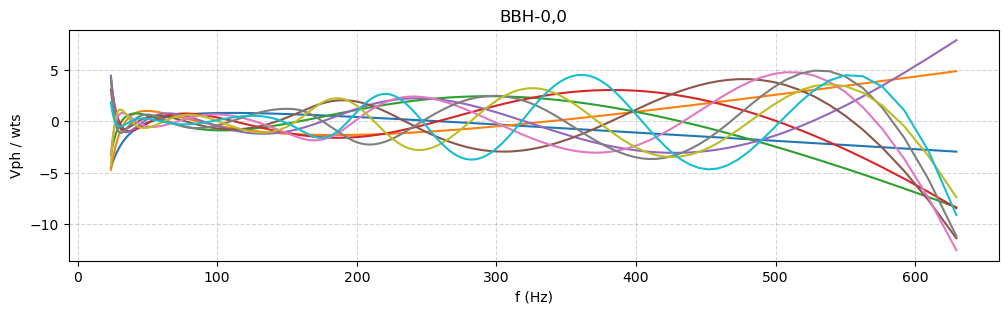

In [25]:
# Checking if the SVD phase basis are smooth
# They better not have kinds or sharp features
plt.figure(figsize=(12,3))
ib=0; isb=0
Up, sp, Vph, mean_phases = SVD_SubBanks[ib][isb]
wts = weights_banks[ib]**0.5
for i in range(10):
    plt.plot(f_phases_banks[ib],Vph[i]/wts)
plt.xlabel('f (Hz)'); plt.ylabel('Vph / wts');
plt.title(f'BBH-{ib},{isb}');

In [26]:
# Checking performance of three cases: 2D calpha grid, 3D calpha grid, 2D + random forest
# for a particular subbank (ib,isb)

ib = 0 # ib is index of bank

rg_rf = RandomForestRegressor(n_estimators=60, max_depth=60, random_state=2)

wt=weights_banks[ib]**0.5
bins=SubBank_Mchirp_bins[ib]
SVD_SubBank=SVD_SubBanks[ib]
cos_exp_f0=[]
cos_exp_f1=[]
cos_exp_f2=[]

for isb in range(len(bins)): # isb is index of subbank
    Up, sp, Vph, mean_phase = SVD_SubBank[isb]
    phases = Up @ np.diag(sp) @ Vph + mean_phase
    ca = Up @ np.diag(sp)
    
    #1
    ca2=ca.copy()
    ca2[:,2:]=0
    ca2=np.rint(ca2*8)/8. # Gridding
    phases_f= ca2 @ Vph + mean_phase
    cos_exp_f0.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases/wt)*wt))))
    
    #2
    ca2=ca.copy()
    ca2[:,3:]=0
    ca2=np.rint(ca2*8)/8. # Gridding
    phases_f= ca2 @ Vph + mean_phase
    cos_exp_f1.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases/wt)*wt))))
    
    #3
    ndims=2
    # if ((ib==0 and isb==2) and (ib==2 and isb==0)): ndims=3
    # (earlier we used ndims=3 for a few cases but now no longer needed)
    ca2=ca.copy(); ca2=np.rint(ca2*8)/8.; ca2[:,ndims:]=0
    
    # Training a RF:
    ind=np.random.choice([0, 1], size=(len(ca),), p=[1./2, 1./2]).astype('bool');
    ca2=ca2[ind]; phases=phases[ind]
    rg_rf.fit(ca[:, :ndims][~ind],ca[:,ndims:10][~ind])
    
    # or directly loading the RF:
    # rg_rf = pickle.load(open(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'RandomForest.pkl'), "rb"))
    
    ca2[:,ndims:10]=rg_rf.predict(ca2[:,:ndims])
    phases_f= ca2 @ Vph + mean_phase
    cos_exp_f2.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases/wt)*wt))))

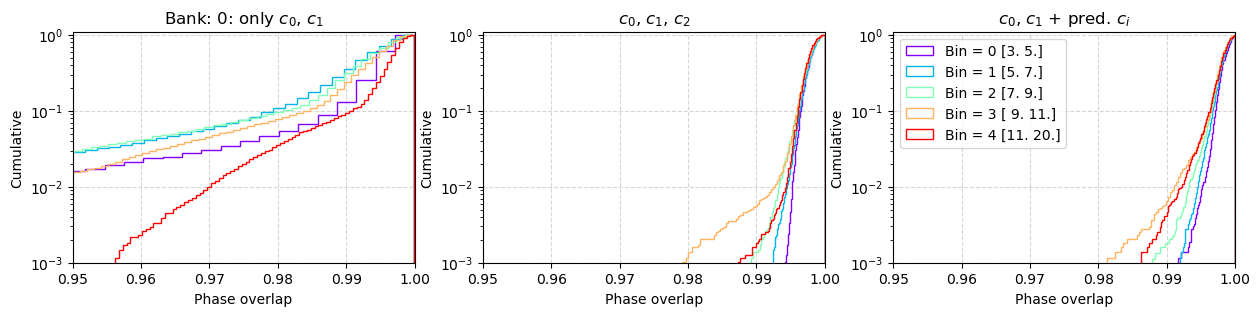

In [27]:
from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, len(bins)))
plt.figure(figsize=(15,3))

plt.subplot(131)
for isb in range(len(bins)):
    _=plt.hist(cos_exp_f0[isb],bins=100,density=True,histtype='step',
            label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb])
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.95,1)
plt.xlabel('Phase overlap'); plt.ylabel('Cumulative')
plt.title('Bank: '+str(ib)+': only $c_0$, $c_1$');

plt.subplot(132)
for isb in range(len(bins)):
    _=plt.hist(cos_exp_f1[isb],bins=100,density=True,histtype='step',
            label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb])
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.95,1)
plt.xlabel('Phase overlap'); plt.ylabel('Cumulative')
plt.title('$c_0$, $c_1$, $c_2$');

plt.subplot(133)
for isb in range(len(bins)):
    _=plt.hist(cos_exp_f2[isb],bins=100,density=True,histtype='step',
            label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb])
    
plt.yscale('log')
plt.legend(loc=2) #loc=(1.05,0)
plt.ylim(0.001,1.1); plt.xlim(0.95,1)
plt.xlabel('Phase overlap'); plt.ylabel('Cumulative')
plt.title('$c_0$, $c_1$ + pred. $c_i$');

In [29]:
# Uncomment for SAVING the SVD related data and the random forest to the sub-banks

# ndims=2 # We are using the same ndims for all sub-banks but change this if you need

# rg_rf = RandomForestRegressor(n_estimators=60, max_depth=60, random_state=2)
# for ib in range(nbanks):
#     SVD_SubBank=SVD_SubBanks[ib]
    
#     for isb in range(SubBankSplits[ib]):
#         sub_dir = os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb))
#         if not os.path.exists(sub_dir):
#             os.makedirs(sub_dir)
#         Up, sp, Vph, mean_phase=SVD_SubBank[isb]
#         ca = Up @ np.diag(sp)
#         np.save(os.path.join(sub_dir,'avg_phase_evolution.npy'),mean_phase)
#         np.save(os.path.join(sub_dir,'svd_phase_basis.npy'),Vph[:10])
#         np.save(os.path.join(sub_dir,'coeffs.npy'),ca[:,:10])
#         np.save(os.path.join(sub_dir,'params.npy'), input_pars[(bank_ids==ib) * (subbank_ids==isb)])
        
#         #   ## Saving the metadata files
#         metadata_path = os.path.join(sub_dir,'metadata.json')
#         if os.path.exists(metadata_path):
#             with open(metadata_path, 'r') as f:
#                 metadata = json.load(f)
#         else:
#             metadata={}
#         metadata['ndims']=ndims; metadata['approximant']='IMRPhenomXHM';
#         metadata['modes']=['22','33','44']
#         metadata['Mchirp_edges']=np.round(SubBank_Mchirp_bins[ib][isb],2)
#         with open(metadata_path, 'w') as f:
#             json.dump(metadata, f, indent=2, cls=utils.NumpyEncoder)

#         #   ## Saving the RF regressor
#         rg_rf.fit(ca[:, :ndims],ca[:,ndims:10]) # Time intensive
#         joblib.dump(rg_rf, os.path.join(sub_dir,'RandomForest.pkl'), compress=3)

### Index in bank.coeffs which gives minimum shift (which is used in conditioning the wf)

In [ ]:
# Run this module after creating the banks
# We use truncate=True in gen_wfs_td_from_fd() to shorten our template wfs.
# If the wfs are not properly shifted before truncation,
# we can lose in SNR. This section ensures a shift such that the SNR loss is negligible.
# By monte carlo, we find wf which has the maximum length and then shift all the wfs by that amount

# Ignore this module if you are only making lower mass banks (Mtot<100 Msol)
# as the length of the wfs is directly related to Mchirp for those
# and we don't need the monte carlo search

In [63]:
# We will calculate the shifts corresponding to calpha waveforms, for calphas which are projections
# of phases of physical wfs used in the construction of banks
# Warning this takes a lot of time to run (20 min)

# List of sub-banks
subbanks = []
for ib in range(nbanks):
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        subbanks.append([ib,isb])

sampling_factor = 2

# Prints the minimum shift and the index which gives it
def min_shift(ind):
    [ib,isb] = subbanks[ind]
    bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
    bank.min_shift_calpha_ind = 0
    bank.set_waveform_conditioning(2**18, 1/2048)
    shifts_bank_min = 0
    coeffs = bank.coeffs[::sampling_factor]
    for i in range(len(coeffs)):
        h = bank.gen_wfs_fd_from_calpha(calpha=coeffs[i], fs_out=bank.fs_fft, log=False)[0]
        wf_whitened_fd = h * bank.wt_filter_fd * np.sqrt(2 * bank.dt)
        _, shifts_bank, _ = bank.get_waveform_conditioning(bank.fftsize, bank.dt, wf_whitened_fd)
        if (shifts_bank_min > shifts_bank): shifts_bank_min = shifts_bank; index = i
    return([shifts_bank_min, index*sampling_factor])

with mp.Pool(ncores) as p:
        min_shifts = p.map(min_shift,np.arange(len(subbanks)))

In [64]:
# This will read the old metadata file and add another entry corresponding to 'min_shift_calpha_ind'

for ind in range(len(subbanks)):
    [ib,isb] = subbanks[ind]
    with open(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'), 'r') as f:
        metadata = json.load(f)
        metadata['min_shift_calpha_ind']=min_shifts[ind][1]
    with open(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2, cls=utils.NumpyEncoder)

### Higher mode SVDs

In [28]:
# As mentioned in the paper, we try to model particular combinations of
# phase difference arrays for HM (e.g. Psi_33(3f) - 3/2 Psi22(2f))
# These combinations have been motivated from the stationary phase approximation formulae for HM

# Either directly load the phases or generate them with the commented out code below

phases_samples = np.load(os.path.join(tbp.wf_DIR, 'phases_samples_33_44.npy'))

In [31]:
# Generating the phases using PhenomXHM

# def gen_phases(i):
#     bank_id=bank_ids[i]; p=input_pars[i]
#     par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
#     phases22 = tg.compute_hplus_hcross(f_unwrap_banks[bank_id], par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
#     phases22 = np.unwrap(np.angle(phases22))
    
#     phases33 = tg.compute_hplus_hcross(f_unwrap_banks[bank_id]*3/2, par_dic,
#                                         'IMRPhenomXHM', [(3, 3),(3,-3)])[0]
#     phases33 = np.unwrap(np.angle(phases33))
#     phases33 = np.interp(f_phases_banks[bank_id],f_unwrap_banks[bank_id], phases33/3-phases22/2) * 3
    
#     phases44 = tg.compute_hplus_hcross(f_unwrap_banks[bank_id]*4/2, par_dic,
#                                         'IMRPhenomXHM', [(4, 4),(4,-4)])[0]
#     phases44 = np.unwrap(np.angle(phases44))
#     phases44 = np.interp(f_phases_banks[bank_id],f_unwrap_banks[bank_id], phases44/4-phases22/2) * 4
#     return(np.c_[phases33,phases44].T)

# ###############################################
# # #Generating the phases from the above function using multiprocessing

# with mp.Pool(ncores) as p:
#         phases_samples = p.map(gen_phases, np.arange(len(bank_ids)))
        
# phases_samples = np.asarray(phases_samples)
# np.save(os.path.join(tbp.wf_DIR,f'phases_samples_33_44.npy'),phases_samples)

In [29]:
def SVD_HM_banks(ib): #range(nbanks)
    wts=weights_banks[ib]**0.5
    bins=SubBank_Mchirp_bins[ib]
    ca_SubBanks=[]; Vph_SubBanks=[]; phases_SubBanks=[]
    for isb in range(len(bins)):
        wts=weights_banks[ib]**0.5
        mask=bank_ids==ib; mask*=subbank_ids==isb
        phases = phases_samples[mask]
        constant = np.sum(phases*weights_banks[ib],axis=-1)
        phases = (phases.T - constant.T).T
        constant[:,0] = constant[:,0] % (np.pi) # phi_ref can absorb the change of 33 phase by pi
        constant[:,1] = constant[:,1] % (2*np.pi)
          
        phases *= wts
        mean_phases = np.mean(phases, axis=0)
        phases -= mean_phases
        Up, sp, Vph = np.linalg.svd(phases[:,0,:], full_matrices=False)
        ca33 = (Up @ np.diag(sp))[:,:ndims_HM]; Vph33 = Vph[:ndims_HM]
        
        Up, sp, Vph = np.linalg.svd(phases[:,1,:], full_matrices=False)
        ca44 = (Up @ np.diag(sp))[:,:ndims_HM]; Vph44 = Vph[:ndims_HM]
        
        ca_SubBanks.append(np.c_[constant, ca33, ca44]);
        Vph_SubBanks.append(np.r_[mean_phases, Vph33, Vph44]);
        phases_SubBanks.append(phases+mean_phases)
    return(ca_SubBanks, Vph_SubBanks, phases_SubBanks)

In [30]:
# Checking the cosines

ib = 8 # id of bank to probe
ndims_HM = 3 # Dimensions of HM phase basis to include

rg_rf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=2)

wt=weights_banks[ib]**0.5
bins=SubBank_Mchirp_bins[ib]
ca_SubBanks, Vph_SubBanks, phases_SubBanks = SVD_HM_banks(ib)
cos_exp_f0=[]; cos_exp_f1=[]; cos_exp_f2=[]

# Loading 22 calphas
dire = os.path.join(tbp.DIR,'BBH_'+str(ib))

for isb in range(len(bins)):
    
    dire2 = os.path.join(dire,'bank_'+str(isb))
    # Number of dimensions used for calpha_22
    ndims_22 = json.load(open(os.path.join(
        tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'), 'r'))['ndims'] 
    ca22 = np.load(os.path.join(dire2,'coeffs.npy'))[:,:ndims_22]#[~mask_outliers]
    
    ca  = ca_SubBanks[isb]; Vph = Vph_SubBanks[isb]; phases = phases_SubBanks[isb]
    
    # Training a RF:
    ind=np.random.choice([0, 1], size=(len(ca),), p=[1./2, 1./2]).astype('bool'); 
    rg_rf.fit(ca22[~ind],ca[~ind])
    ca22_grid = np.rint(ca22*8)/8.;
    ca_grid_pred = rg_rf.predict(ca22_grid[ind])
    
    constant = ca[:,:2]; ca = ca[:,2:]; 
    mean_phase = Vph[:2,:]; Vph = Vph[2:,:]

    for mode in range(2):
        ca_grid=np.zeros_like(ca[:,mode*ndims_HM:(mode+1)*ndims_HM])
        phases_f = ca_grid @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:] + mean_phase[mode]
        cos_exp_f0.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases[:,mode,:]/wt)*wt))))

        ca_grid=ca[:,mode*ndims_HM:(mode+1)*ndims_HM].copy()
        ca_grid=np.rint(ca_grid*8)/8. # Gridding
        phases_f = ca_grid @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:]  + mean_phase[mode]
        cos_exp_f1.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases[:,mode,:]/wt)*wt))))
    
        phases_f= ca_grid_pred[:,2+mode*ndims_HM:2+(mode+1)*ndims_HM] @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:] + mean_phase[mode]
        cos_exp_f2.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases[ind,mode,:]/wt)*wt))))

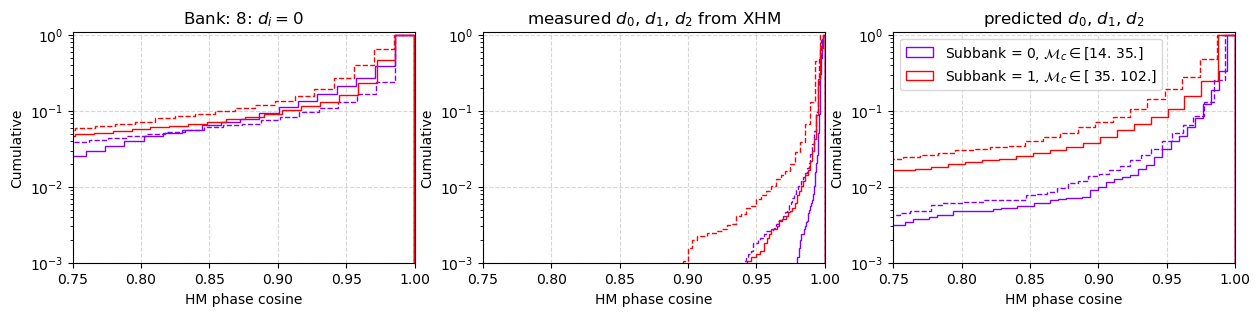

In [31]:
# Making cosine plots
# c_alphas were for 22 phases, d_alphas are similar coefficients but for (HM-22) phases

from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, len(bins)))
plt.figure(figsize=(15,3))

plt.subplot(131)
for isb in range(len(bins)):
    i=2*isb
    plt.hist(cos_exp_f0[i+0],bins=100,density=True,histtype='step',
             label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f0[i+1],bins=100,density=True,histtype='step',
             label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='dashed');
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.75,1)
plt.xlabel('HM phase cosine'); plt.ylabel('Cumulative')
plt.title(r'Bank: '+str(ib)+': $d_i = 0$');

plt.subplot(132)
for isb in range(len(bins)):
    i=2*isb
    plt.hist(cos_exp_f1[i+0],bins=100,density=True,histtype='step',
             label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f1[i+1],bins=100,density=True,histtype='step',
             label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='--');
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.75,1)
plt.xlabel('HM phase cosine'); plt.ylabel('Cumulative')
plt.title('measured $d_0$, $d_1$, $d_2$ from XHM');

plt.subplot(133)
for isb in range(len(bins)):
    i=2*isb
    plt.hist(cos_exp_f2[i+0],bins=100,density=True,histtype='step',
             label='Subbank = '+str(isb)+r', $\mathcal{M}_c\in$'+ str(np.round(bins[isb])),
             cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f2[i+1],bins=100,density=True,histtype='step',cumulative=True,color=color[isb],ls='--');
    
plt.yscale('log')
plt.legend(loc=2) #loc=(1.05,0)
plt.ylim(0.001,1.1); plt.xlim(0.75,1)
plt.xlabel('HM phase cosine'); plt.ylabel('Cumulative')
plt.title('predicted $d_0$, $d_1$, $d_2$');

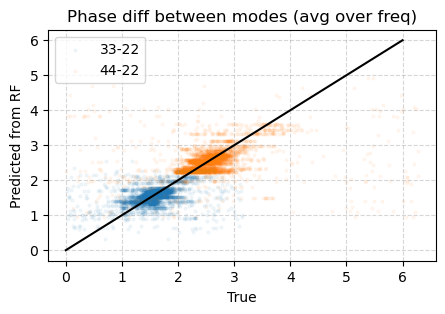

In [51]:
plt.scatter(constant[ind,0],ca_grid_pred[:,0],s=4,alpha=0.05,label='33-22')
plt.scatter(constant[ind,1],ca_grid_pred[:,1],s=4,alpha=0.05,label='44-22')
plt.plot(np.arange(0,7),np.arange(0,7),c='k')
plt.legend(); plt.xlabel('True'); plt.ylabel('Predicted from RF'); plt.title('Phase diff between modes (avg over freq)');

In [52]:
# Uncomment to SAVE the SVDs and the random forest to the template banks

# rg_rf = RandomForestRegressor(n_estimators=50, max_depth=60, random_state=2)
# for ib in range(nbanks):
#     ca_SubBanks, Vph_SubBanks, _ = SVD_HM_banks(ib)
   
#     for isb in range(SubBankSplits[ib]):
#         dire_HM = os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'HM')
#         if not os.path.exists(dire_HM):
#             os.makedirs(dire_HM)
#         caHM  = ca_SubBanks[isb]; Vph = Vph_SubBanks[isb];
#         np.save(os.path.join(dire_HM,f'avg_phase_evolution_HM.npy'),Vph[:2])
#         np.save(os.path.join(dire_HM,f'svd_phase_basis_HM.npy'),Vph[2:])

#         ndims_22 = json.load(open(os.path.join(
#               tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'), 'r'))['ndims']
#         ca22 = np.load(os.path.join(os.path.dirname(dire_HM),'coeffs.npy'))[:,:ndims_22]
#         rg_rf.fit(ca22, caHM) # Time intensive
#         joblib.dump(rg_rf, os.path.join(dire_HM,f'RandomForest_HM.pkl'), compress=3)

## Extras

### Code for roughly determining number of sub-bank splits

In [ ]:
# We want to keep wfs of similar temporal duration (to within roughly a factor of 2) within each subbank
# The temporal duration is calculated using get_tight_support()
# The reason for these divisions is that the number of background triggers 
# is correlated with the duration of the waveform, so we want to club together wfs of similar duration

In [18]:
# This is slightly changed version of the function get_waveform_conditioning() in template_bank_generator_HM.py

import utils
import params

def get_tight_support(fftsize, dt, whitened_wf_fd):
        """
        Useful function to get conditioning parameters for whitened waveforms
        :param fftsize: Number of time-domain indices
        :param dt: Time domain step size (s)
        :param whitened_wf_fd: len(rfftfreq(fftsize)) array with FD whitened
                               waveform (does not need to be linear free)
        """
        # Find TD envelope of waveform
        whitened_wf_td_cos = utils.IRFFT(whitened_wf_fd, n=fftsize)
        whitened_wf_td_sin = utils.IRFFT(whitened_wf_fd * 1j, n=fftsize)
        envelope_sq = whitened_wf_td_cos ** 2 + whitened_wf_td_sin ** 2

        # Rolling the wf to start at the peak
        envelope_sq = np.roll(envelope_sq,-np.argmax(envelope_sq))

        # Look at how weight builds up
        lind = 0
        rind = len(envelope_sq)
        totalwt = np.sum(envelope_sq)
        currentwt = 0
        while currentwt < (1. - params.WFAC_WF) * totalwt:
            dlwt = envelope_sq[lind]
            drwt = envelope_sq[rind - 1]
            if dlwt > drwt:
                lind += 1
                currentwt += dlwt
            else:
                rind -= 1
                currentwt += drwt
        tight_support_wf = fftsize - rind + lind

        return tight_support_wf

In [19]:
fftsize = 2**18
dt = 1/2048; df = 1/(fftsize*dt)
fs_fft = np.fft.rfftfreq(fftsize,dt)

In [20]:
def waveform_duration(p):
    # p: input pars
    par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
    h = np.zeros_like(fs_fft, dtype=np.complex128)
    h[1:] = tg.compute_hplus_hcross(fs_fft[1:], par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
    h /= tg.DEFAULT_ASDF(fs_fft) # Whitening
    amp, phase = np.abs(h), np.unwrap(np.angle(h))
    phase_linfree = tg.remove_linear_component(
                [phase], fs_fft, amp * np.sqrt(df))[0]
    h = amp * np.exp(1j * phase_linfree)
    return(get_tight_support(fftsize=fftsize, dt=dt, whitened_wf_fd=h))

In [18]:
ib=0
mchirp_bank = Mchrandom[bank_ids==ib]
# We are assuming the wf duration is perfectly correlated with the chirp mass
# (which is approximately true for low-mass inspiral-dominated wfs)
max_ind = np.argmin(abs(mchirp_bank-np.percentile(mchirp_bank,97)))
min_ind = np.argmin(abs(mchirp_bank-np.percentile(mchirp_bank,3)))
# approximate duration ratio within bank
ratio = waveform_duration(input_pars[bank_ids==ib][min_ind])/waveform_duration(input_pars[bank_ids==ib][max_ind])

# Number of subbanks in bank (round the following to nearest integer)
np.log(ratio)/np.log(2)

3.4061757082651205

In [32]:
# Dividing the banks based on mchirp and calculating the duration ratio at the edge of each subbank
# Should be very roughly in increments of 2 
# (except for the first and last subbanks where a bit more extreme values are allowed)
nsubbanks = 3 #SubBankSplit[ib]
IndSplit=[]; 
IndSplit.append(mchirp_bank.argmin())
for i in range(1,nsubbanks):
    _=np.percentile(mchirp_bank,i*100/nsubbanks)
    IndSplit.append(np.where(mchirp_bank==amin(mchirp_bank[mchirp_bank>_]))[0][0])
IndSplit.append(mchirp_bank.argmax())
IndSplit=IndSplit[::-1]; IndSplit

duration_ratio = np.array([waveform_duration(input_pars[bank_ids==ib][ind]) for ind in IndSplit]).astype(float)
duration_ratio /= duration_ratio[0]
duration_ratio

array([1.        , 1.85397727, 2.59943182, 8.09431818])

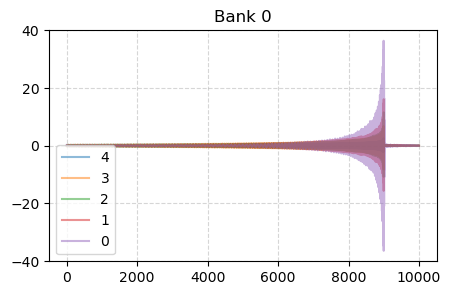

In [149]:
# Plot showing wfs at the edges of the subbanks
h = np.zeros_like(fs_fft, dtype=np.complex128)
for i in range(nsubbanks,-1,-1):
    p = input_pars[bank_ids==ib][IndSplit[i]]
    par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
    h[1:] = tg.compute_hplus_hcross(fs_fft[1:], par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
    h /= tg.DEFAULT_ASDF(fs_fft) # Whitening
    plt.plot(np.roll(np.fft.irfft(h),-1000)[-10000:], alpha=0.5, label=f'{i}')
plt.title(f'Bank {ib}'); plt.legend()

### SVD for amplitudes

In [ ]:
# Each bank is assigned to a reference amplitude, given by Af_kmeans_ii
# However, for banks with very mass BHs, amplitudes of waveforms can vary significantly within banks,
# we therefore calculate amplitudes as a function of calpha of 22 phase
# These calphas provide info on the mass ratio and chieff, which can then determine amplitudes

# This is an optional refinement step, we saw that this correction only affects the
# very high mass banks (BBH-15, 16)

In [ ]:
ib = 16 # id of bank to probe
ndims_HM = 2 # Dimensions of amp basis to include

ca_SubBanks=[]; Vph_SubBanks=[]
for ib in [ib]: #range(nbanks)
    bins=SubBank_Mchirp_bins[ib]
    _=[]; _2=[]
    for isb in range(len(bins)):
        mask=bank_ids==ib; mask*=subbank_ids==isb
        amps = amps_samples[:,0,:][mask]-Af_kmeans_22[ib]
        Up, sp, Vph = np.linalg.svd(amps, full_matrices=False)
        ca22 = (Up @ np.diag(sp))[:,:ndims_HM]; Vph22 = Vph[:ndims_HM]
        
        amps = amps_samples[:,1,:][mask]-Af_kmeans_33[ib]
        Up, sp, Vph = np.linalg.svd(amps, full_matrices=False)
        ca33 = (Up @ np.diag(sp))[:,:ndims_HM]; Vph33 = Vph[:ndims_HM]
        
        amps = amps_samples[:,2,:][mask]-Af_kmeans_44[ib]
        Up, sp, Vph = np.linalg.svd(amps, full_matrices=False)
        ca44 = (Up @ np.diag(sp))[:,:ndims_HM]; Vph44 = Vph[:ndims_HM]
        
        _.append(np.c_[ca22, ca33, ca44]); _2.append(np.array([Vph22, Vph33, Vph44]))

    ca_SubBanks.append(_); Vph_SubBanks.append(_2)

In [ ]:
# Checking the cosines

rg_rf = RandomForestRegressor(n_estimators=60, max_depth=60, random_state=2) #J

bins=SubBank_Mchirp_bins[ib]
cos_exp_f0=[]; cos_exp_f1=[]; cos_exp_f2=[]
ca_SubBank = ca_SubBanks[0]; Vph_SubBank = Vph_SubBanks[0] # 0 corresponds to ib

# Loading 22 calphas
dire = os.path.join(tbp.DIR,'BBH_'+str(ib))

for isb in range(len(bins)):
    
    dire2 = os.path.join(dire,'bank_'+str(isb))
    caPh = np.load(os.path.join(dire2,'coeffs.npy'))
    mask=bank_ids==ib; mask*=subbank_ids==isb
    
    ca  = ca_SubBank[isb]
    Vph = Vph_SubBank[isb]
    
    amps_f= Af_kmeans_22[ib]
    cos_exp_f0.append(np.sum(amps_samples[:,0,:][mask] * amps_f * weights, axis=-1))
    amps = amps_samples[:,1,:][mask]
    amps_f= Af_kmeans_33[ib]
    cos_exp_f0.append(np.sum(amps_samples[:,1,:][mask] * amps_f * weights, axis=-1))
    amps = amps_samples[:,2,:][mask]
    amps_f= Af_kmeans_44[ib]
    cos_exp_f0.append(np.sum(amps_samples[:,2,:][mask] * amps_f * weights, axis=-1))
    
    ca_grid=np.rint(ca*8)/8. # Gridding
    amps_f= ca_grid[:,:2] @ Vph[0] + Af_kmeans_22[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f1.append(np.sum(amps_samples[:,0,:][mask] * amps_f * weights, axis=-1))
    amps_f= ca_grid[:,2:4] @ Vph[1] + Af_kmeans_33[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f1.append(np.sum(amps_samples[:,1,:][mask] * amps_f * weights, axis=-1))
    amps_f= ca_grid[:,4:6] @ Vph[2] + Af_kmeans_44[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f1.append(np.sum(amps_samples[:,2,:][mask] * amps_f * weights, axis=-1))
    
    if((ib==0 and isb==2) or (ib==0 and isb==3) or (ib==1 and isb==0) or (ib==2 and isb==0)): ndims=3
    else: ndims=2
    caPh_grid = caPh.copy(); caPh_grid = np.rint(caPh_grid*8)/8.; caPh_grid[:,ndims:]=0
    
    # Training a RF:
    ind=np.random.choice([0, 1], size=(len(ca),), p=[1./2, 1./2]).astype('bool');
    ca_grid = ca_grid[ind]; caPh_grid = caPh_grid[ind]
    rg_rf.fit(caPh[:, :ndims][~ind],ca[~ind])
    
    # or directly loading the RF:
    # rg_rf = pickle.load(open(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'RandomForest.pkl'), "rb"))
    
    ca_grid = rg_rf.predict(caPh_grid[:,:ndims])
    amps_f= ca_grid[:,:2] @ Vph[0] + Af_kmeans_22[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f2.append(np.sum(amps_samples[:,0,:][mask][ind] * amps_f * weights, axis=-1))
    
    amps_f= ca_grid[:,2:4] @ Vph[1] + Af_kmeans_33[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f2.append(np.sum(amps_samples[:,1,:][mask][ind] * amps_f * weights, axis=-1))
    
    amps_f= ca_grid[:,4:] @ Vph[2] + Af_kmeans_44[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f2.append(np.sum(amps_samples[:,2,:][mask][ind] * amps_f * weights, axis=-1))

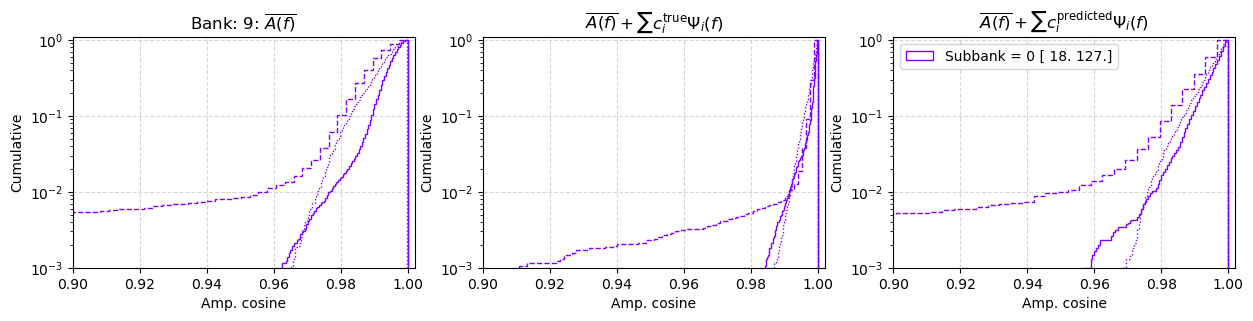

In [ ]:
# Making cosine plots
# c_alphas were for 22 phases, d_alphas are similar coefficients but for (HM-22) phases

from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, len(bins)))
plt.figure(figsize=(15,3))

plt.subplot(131)
for isb in range(len(bins)):
    ind=3*isb
    plt.hist(cos_exp_f0[ind+0],bins=100,density=True,histtype='step',label='Subbank = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f0[ind+1],bins=100,density=True,histtype='step',label='Subbank = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='dashed');
    plt.hist(cos_exp_f0[ind+2],bins=100,density=True,histtype='step',label='Subbank = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='dotted');
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.9,1.002)
plt.xlabel('Amp. cosine'); plt.ylabel('Cumulative')
plt.title(r'Bank: '+str(ib)+': $\overline{A(f)}$');

plt.subplot(132)
for isb in range(len(bins)):
    ind=3*isb
    plt.hist(cos_exp_f1[ind+0],bins=100,density=True,histtype='step',label='Subbank = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f1[ind+1],bins=100,density=True,histtype='step',label='Subbank = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='dashed');
    plt.hist(cos_exp_f1[ind+2],bins=100,density=True,histtype='step',label='Subbank = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='dotted');
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.9,1.002)
plt.xlabel('Amp. cosine'); plt.ylabel('Cumulative')
plt.title('$\overline{A(f)} + \sum c^\mathrm{true}_i \Psi_i(f)$');

plt.subplot(133)
for isb in range(len(bins)):
    ind=3*isb
    plt.hist(cos_exp_f2[ind+0],bins=100,density=True,histtype='step',label='Subbank = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f2[ind+1],bins=100,density=True,histtype='step',cumulative=True,color=color[isb],ls='dashed');
    plt.hist(cos_exp_f2[ind+2],bins=100,density=True,histtype='step',cumulative=True,color=color[isb],ls='dotted');
    
plt.yscale('log')
plt.legend(loc=2) #loc=(1.05,0)
plt.ylim(0.001,1.1); plt.xlim(0.9,1.002)
plt.xlabel('Amp. cosine'); plt.ylabel('Cumulative')
plt.title('$\overline{A(f)} + \sum c^\mathrm{predicted}_i \Psi_i(f)$');

In [ ]:
# Saving the SVD basis and the random forest

rg_rf = RandomForestRegressor(n_estimators=60, max_depth=60, random_state=2)

# ## If remaking the template banks, first remove all the old files
# for ib in range(nbanks):
#     for isb in range(SubBankSplits[ib]):
#         dire2 = os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb))
#         try:
#             os.remove(os.path.join(dire2,f'svd_amp_basis.npy'))
#             os.remove(os.path.join(dire2,f'RandomForest_amps.pkl'))
#         except: pass

# We are only saving the amplitude profiles for particular banks (rest of the banks will use constant amplitudes)
for ib in [ib]: #range(nbanks)
    ca_SubBank=ca_SubBanks[0]; Vph_SubBank=Vph_SubBanks[0]
    
    for isb in range(SubBankSplits[ib]):
        dire2 = os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb))
        # #os.makedirs(dire2)
        np.save(os.path.join(dire2,f'svd_amp_basis.npy'),Vph_SubBank[isb]*Aref)

        ndims22=2

        ca22 = np.load(os.path.join(dire2,'coeffs.npy'))[:,:ndims22]
        rg_rf.fit(ca22, ca_SubBank[isb]) # Time intensive
        joblib.dump(rg_rf, os.path.join(dire2,f'RandomForest_amps.pkl'), compress=3)

In [ ]:
# Note that files are only saved for select banks:
# BBH 4,5,6,7,9,15,16 
4,15,16

# 2. using Template_bank_generator class

In [32]:
reload(tg)
reload(tbp);

In [33]:
ib=7; # Bank number
isb=1 # Sub-bank number
fs_fft = np.fft.rfftfreq(2**18, 1/2048)

In [34]:
bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
bank.set_waveform_conditioning(2**18, 1/2048)

In [35]:
f_phase = bank.fs_basis
fmin = bank.fs_basis[0]; fmax = bank.fs_basis[-1];

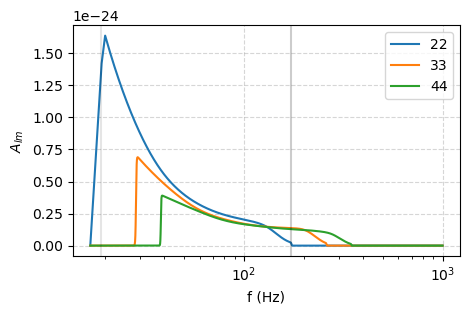

In [36]:
fig, ax = plt.subplots()
ax.semilogx(bank.amp[:, 0], bank.amp[:, 1], label='22')
ax.semilogx(bank.amp[:, 0], bank.amp[:, 2], label='33')
ax.semilogx(bank.amp[:, 0], bank.amp[:, 3], label='44')
plt.axvline(x=fmin,color = 'k',alpha=0.1); plt.axvline(x=fmax,color = 'k',alpha=0.2);
plt.legend()
plt.xlabel('f (Hz)'); plt.ylabel('$A_{lm}$');

In [37]:
ca_grid = bank.get_coeff_grid(delta_calpha=tbp.delta_calpha[f'BBH_{ib}'])
phases = bank.gen_phases_from_calpha(calpha=ca_grid[0], fs_out=fs_fft)

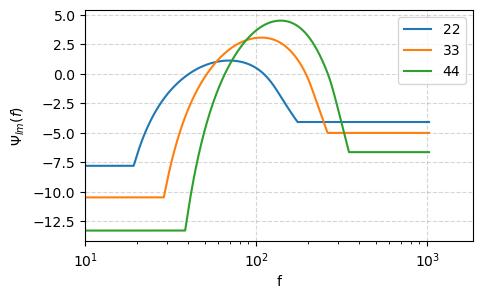

In [38]:
plt.semilogx(fs_fft, phases[0])
plt.semilogx(fs_fft, phases[1])
plt.semilogx(fs_fft, phases[2])
plt.legend(['22','33','44'])
plt.xlabel('f'); plt.ylabel(r'$\Psi_{lm}(f)$')
plt.xlim(1e1);

In [39]:
wf = bank.gen_whitened_wfs_td(calpha=ca_grid[5])
wf = np.roll(wf,-10000,axis=-1)

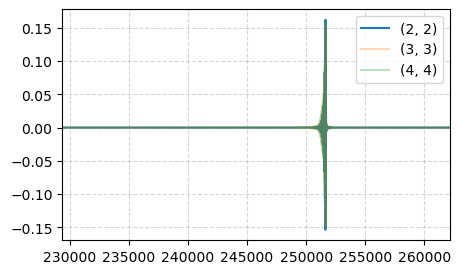

In [40]:
fig, ax = plt.subplots()
ax.plot(wf[0], label='(2, 2)')
ax.plot(wf[1], alpha=0.3, label='(3, 3)')
ax.plot(wf[2], alpha=0.3, label='(4, 4)')
ax.set_xlim((bank.fftsize - bank.support_whitened_wf, bank.fftsize))
ax.legend();

In [41]:
# For checking the number of templates in each subbank (can also use the function bank.ntemplates())

templates = []
for ib in range(tbp.nbanks):
    _ = []
    for isb in range(tbp.nsubbanks['BBH_'+str(ib)]):
        bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),
                                                      'bank_'+str(isb),'metadata.json'))
        _.append(len(bank.get_coeff_grid(delta_calpha = tbp.delta_calpha[f'BBH_{ib}'],
                                          fudge=tbp.fudge[f'BBH_{ib}'])))
    templates.append(_)
    
for ib in range(tbp.nbanks):
    print(f'Bank {ib}: templates {templates[ib]}')
    
print(f'Total number of templates is {np.sum(np.concatenate(templates))}')

Bank 0: templates [10641, 1638, 787, 475, 311]
Bank 1: templates [1097, 185, 107]
Bank 2: templates [443, 87, 62]
Bank 3: templates [2015, 621, 341]
Bank 4: templates [353, 83, 65]
Bank 5: templates [703, 257, 184]
Bank 6: templates [198, 94, 59]
Bank 7: templates [224, 73]
Bank 8: templates [100, 84]
Bank 9: templates [51]
Bank 10: templates [31]
Bank 11: templates [20]
Bank 12: templates [10]
Bank 13: templates [6]
Bank 14: templates [4]
Bank 15: templates [3]
Bank 16: templates [3]
Total number of templates is 21415


# 3. Test effectualness

In [ ]:
# We calculate the effectualness for a particular sub-bank in this section

In [ ]:
# Creating samples of input parameters with appropriate priors
# Load using the following or uncomment the code in the next cell:

# Make a pars_test similar to the input_pars array in the first section
# by using a different random number seed when sampling the parameters
pars_test = np.load(os.path.join(tbp.wf_DIR,'Testing_effectualness','pars_test.npy')) 
# bank_ids_test similar to the bank_ids array in the first section corresponding to pars_test
bank_ids_test = np.load(os.path.join(tbp.wf_DIR,'Testing_effectualness','bank_ids_test.npy'))

# Deriving Mchirp_test
_=np.exp(np.log(pars_test[:,1]/pars_test[:,0]))
_=_/(1+_)**2
Mchirp_test= (pars_test[:,0] + pars_test[:,1])*_**(3/5)

# Other coordinates, in case they're needed for probing the low-effectualness regions
Mrandom = pars_test[:,0] + pars_test[:,1]
lnqrandom = np.log(pars_test[:,1]/pars_test[:,0])
[chieffrandom , cumchidiffrandom] = inverse_transform(pars_test[:,:4].T)

In [17]:
# Use this cell only if you want to create a different bank_ids_test than already loaded above
# This cell determines the banks of the test wfs using same code as the 
# earlier section: 'Generate input waveforms & split banks by amplitude'.

# with mp.Pool(ncores) as p:
#         amps_samples = np.abs(p.starmap(amps_HM,
#                            ((f_amp, pars, False) for pars in pars_test)))

# amps_samples /= Aref
# _ = np.sum(weights*amps_samples**2,axis=-1)**0.5
# for i in range(len(amps_samples)):
#     amps_samples[i] = (amps_samples[i].T/_[i]).T

# bank_ids_test = kmeans.predict(amps_samples)
# bank_ids_test = np.asarray([np.where(order == b)[0][0] for b in bank_ids_test])

In [45]:
# Creating an samples of inclination corresponding to 22 brightness,
# inclination distribution is taken from https://arxiv.org/abs/1102.5421

InclArr=np.zeros(30000); j=0
while (j<30000):
    c=np.random.rand(); _=((1+6*c**2+c**4)**1.5)/(8**1.5)
    if(_ >np.random.rand()): 
        InclArr[j]=c;
        j+=1;

InclArr = np.arccos(InclArr)

In [46]:
# Reloading the sub-bank, if needed
# reload(tg)

ib=12; # Bank number
isb=0 # Sub-bank number

# Try different values of delta_calpha to see the effectualness
# and then save the final value to template_bank_params_O3a.py
# Reducing delta_calpha reduces discreteness effects but
# increases the number of templates (and cost of the search)
delta_calpha = tbp.delta_calpha[f'BBH_{ib}']

bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),
                                              'bank_'+str(isb),'metadata.json'))
bank.set_waveform_conditioning(2**18, 1/2048)

# Finding the pars_test corresponding to the particular sub-bank 

mask2 = (Mchirp_test[bank_ids_test==ib]<=bank.mchirp_edges[1])
mask2 *= (Mchirp_test[bank_ids_test==ib]>bank.mchirp_edges[0])
pars_test_bank = pars_test[bank_ids_test==ib][mask2]

In [47]:
def calc_effectualness(pars_ind, compare_with_22only=True, search_full_bank=False):
    '''
    :param pars_ind: We specify only certain indices at a time to use less memory per core
    :param compare_with_22only: Boolean flag whether to compare the effectualness with a 22-only bank
    :param search_full_bank: Flag indicating whether to search the full bank.
            If false (default), we first find the best-fit calpha template and
            only take the overlap with that. Otherwise, we take overlaps with
            all templates in bank (more expensive).
            Suggestion: Better to not use this flag with multiprocessing as it can consume a lot
            of memory.
    '''
    # First making test waveforms (lwfs = log of wfs)
    fs = bank.fs_unwrap
    lwfs = np.zeros((len(pars_ind),len(bank.fs_fft)),dtype='complex64'); # Test wfs: 22 + HM
    lwfs22 = np.zeros((len(pars_ind),len(fs)),dtype='complex64') # Test wfs: 22
    mask = bank.fs_fft>15
    lwfs[:,~mask] = -np.inf;
    for i, ind in enumerate(pars_ind):
        p = pars_test_bank[ind]
        par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]; 
        par_dic['iota'] = InclArr[ind]
        h = tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
        lwfs22[i] = np.log(np.abs(h)) + 1j * np.unwrap(np.angle(h))

        h = tg.compute_hplus_hcross(bank.fs_fft[mask], par_dic, 'IMRPhenomXHM',
                        [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4),(2,-2), (2,-1), (3,-3), (3,-2), (4,-4)])[0]
        lwfs[i,mask] = np.log(np.abs(h)) + 1j * np.unwrap(np.angle(h))
    
    lwfs22 = tg.upsample_lwfs(lwfs22, fs, bank.fs_fft)
    
    # Calculating effectualness of the wfs
    if compare_with_22only:
        return (# Test wfs: 22, Bank: 22
                np.c_[bank.test_effectualness(wfs_fd=lwfs22, delta_calpha=delta_calpha, HM=False,
                            do_optimization=True, search_full_bank=search_full_bank)[:,1],
                # Test wfs: 22+HM, Bank: 22
                bank.test_effectualness(wfs_fd=lwfs, delta_calpha=delta_calpha, HM=False,
                            do_optimization=True, search_full_bank=search_full_bank)[:,1],
                # Test wfs: 22+HM, Bank: 22+HM
                bank.test_effectualness(wfs_fd=lwfs, delta_calpha=delta_calpha, wfs_22_fd=lwfs22, HM=True,
                            do_optimization=True, search_full_bank=search_full_bank)[:,1]])
    
    else:
        # Test wfs: 22+HM, Bank: 22+HM
        return (bank.test_effectualness(wfs_fd=lwfs, delta_calpha=delta_calpha, wfs_22_fd=lwfs22, HM=True,
                            do_optimization=True, search_full_bank=search_full_bank)[:,1])

In [ ]:
nwfs = 200
p = mp.Pool(ncores)
# First calculate the effectualness without searching for full bank
search_full_bank = False
effectualness = p.starmap(calc_effectualness,
                (([2*i, 2*i+1], True, search_full_bank) for i in np.arange(nwfs//2)))
# The boolean args are compare_with_22only and search_full_bank
# We group the input wfs in sets of 2 to use less memory per core in the multiprocess

p.close(); p.join()
effectualness = np.array(effectualness).reshape(-1,3)
# effectualness = np.ndarray.flatten(np.array(effectualness))

In [ ]:
# For the wfs with match lower than a certain threshold, 
# calculate the effectualness by searching with the full bank
# Warning: this cell can take a long time to run 
# (especially for banks with large number of templates)
# and this cell could be skipped

search_full_bank = True
mask = effectualness[:,2]<0.95
if np.count_nonzero(mask)>0:
    effectualness_improved = []
    for wf_ind in np.arange(nwfs)[mask]:
        effectualness_improved.append(calc_effectualness([wf_ind], compare_with_22only=True,
                                            search_full_bank=search_full_bank))
    effectualness[mask] = np.concatenate(effectualness_improved)

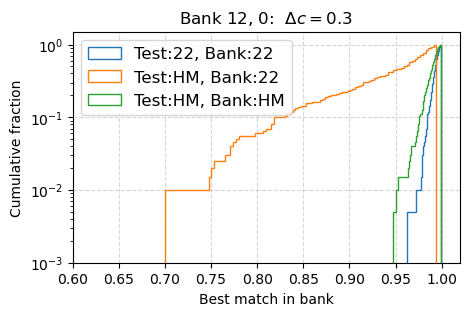

In [50]:
plt.hist(effectualness[:,0],bins=100,histtype='step',density=True, cumulative=True,label='Test:22, Bank:22')
plt.hist(effectualness[:,1],bins=100,histtype='step',density=True, cumulative=True, label='Test:HM, Bank:22')
plt.hist(effectualness[:,2],bins=100,histtype='step',density=True, cumulative=True, label='Test:HM, Bank:HM')
plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.yscale('log'); plt.xlabel('Best match in bank'); plt.ylabel('Cumulative fraction'); 
plt.legend(loc=2,fontsize=12); plt.xlim(left=0.6,right=1.02); plt.ylim(1e-3,1.5)
plt.title(rf'Bank {ib}, {isb}:  $\Delta c=${delta_calpha}');

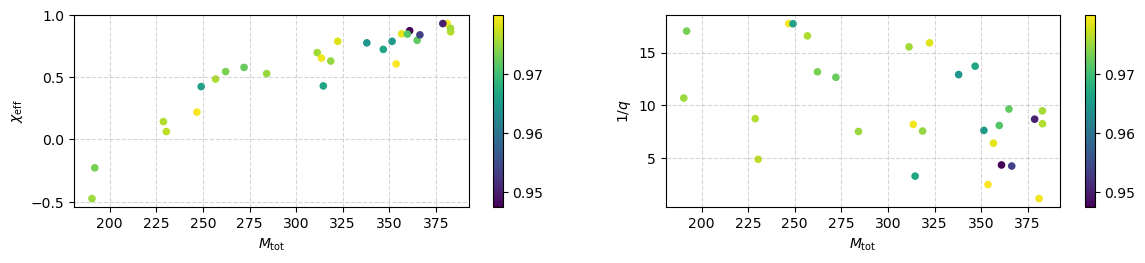

In [51]:
# Parameter space for the worst match wfs

mask = effectualness[:,2]<.98
plt.figure(figsize=(14,2.5))
plt.subplot(121)
plt.scatter(Mrandom[bank_ids_test==ib][mask2][:nwfs][mask],chieffrandom[bank_ids_test==ib][mask2][:nwfs][mask],
            c=effectualness[:,2][mask],s=20,cmap='viridis'); plt.colorbar()
plt.xlabel(r'$M_\mathrm{tot}$'); plt.ylabel(r'$\chi_\mathrm{eff}$')
plt.subplot(122)
plt.scatter(Mrandom[bank_ids_test==ib][mask2][:nwfs][mask],1/np.exp(lnqrandom[bank_ids_test==ib][mask2][:nwfs][mask]),
            c=effectualness[:,2][mask],s=20,cmap='viridis'); plt.colorbar()
plt.xlabel(r'$M_\mathrm{tot}$'); plt.ylabel(r'$1/q$');

### Extra: Checking effectualness in bulk for all bank

In [504]:
# Ignore the cells below in this sub-section:
# These have the same code as above but running in bulk for all banks
# We use the astrophysical prior samples from notebook #2
# to check the bulk effectualness.
# Warning, the following codes take a lot of time to run

In [24]:
nwf_init=1e7
input_pars = np.load(os.path.join(tbp.template_prior_DIR,
 f'samples_info_{nwf_init:.1e}.npz'), allow_pickle=True)['input_pars']

bank_ids = np.load(os.path.join(tbp.template_prior_DIR,
 f'samples_info_{nwf_init:.1e}.npz'), allow_pickle=True)['bank_ids']
subbank_ids = np.load(os.path.join(tbp.template_prior_DIR,
 f'samples_info_{nwf_init:.1e}.npz'), allow_pickle=True)['subbank_ids']

In [ ]:
nwfs = 1000
for ib in range(tbp.nbanks):
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        delta_calpha = tbp.delta_calpha[f'BBH_{ib}']
        bank = tg.TemplateBank.from_json(
            os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
        bank.set_waveform_conditioning(2**18, 1/2048)
        # Finding the pars_test corresponding to the particular sub-bank
        pars_test_bank = input_pars[(bank_ids==ib)*(subbank_ids==isb)]
        search_full_bank = False
        # Using multi-processing
        p = mp.Pool(20)
        effectualness = p.starmap(calc_effectualness, 
                    (([2*i, 2*i+1], True, search_full_bank) for i in np.arange(nwfs//2)))
        p.close(); p.join()
        effectualness = np.array(effectualness).reshape(-1,3)
        
        mask = effectualness[:,2]<0.95
        search_full_bank = True
        if np.count_nonzero(mask)>0:
            effectualness_improved = []
            for wf_ind in np.arange(nwfs)[mask]:
                effectualness_improved.append(calc_effectualness([wf_ind], 
                                compare_with_22only=True,search_full_bank=search_full_bank))
            effectualness[mask] = np.concatenate(effectualness_improved)
        np.save(plot_data_dir+f'Effectualness/Bank_{ib}_{isb}.npy', effectualness)

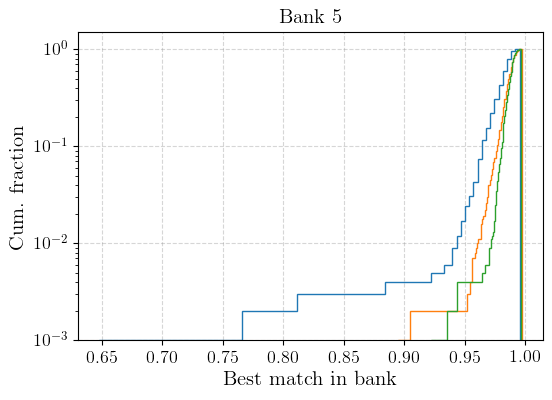

In [33]:
# Checking effectualness for all sub-banks in a bank
ib=5

for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
    plt.hist(np.load(plot_data_dir+f'Effectualness/Bank_{ib}_{isb}.npy')[:,2],
             bins=100,histtype='step',density=True, cumulative=True);
    
plt.yscale('log'); plt.ylim(1e-3,1.5)
plt.xlabel('Best match in bank'); plt.ylabel('Cum. fraction'); plt.title(f'Bank {ib}');

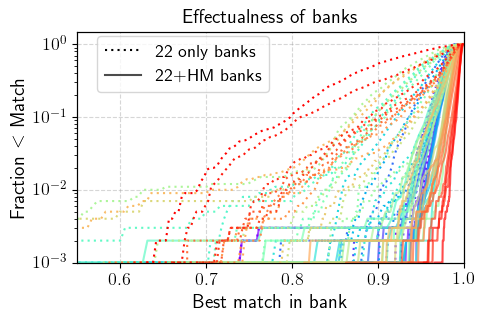

In [41]:
# Checking effectualness for all sub-banks in a bank
fig, ax = plt.subplots()
ax.set_yscale('log')

icolor=0; colors = plt.cm.rainbow(np.linspace(0,1,35))
for ib in range(17):
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        _ = np.load(plot_data_dir+f'Effectualness/Bank_{ib}_{isb}.npy')
        if (_.ndim==1): print(ib,isb)
        a, b = np.histogram(_[:,1],bins=100)
        ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color=colors[icolor],ls='--', dashes=(1, 2))
        a, b = np.histogram(_[:,2],bins=100)
        ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color=colors[icolor], alpha=0.7)
        # ax.hist(_[:,2],bins=100,histtype='step',density=True, cumulative=True, color='gray',alpha=0.8);
        # ax.hist(_[:,1],bins=100,histtype='step',density=True, cumulative=True, color='gray', ls='dashed');
        icolor+=1

ax.set_ylim(bottom=1e-3,top=1.5); ax.set_xlim(left=0.55,right=1.);
ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)
ax2.plot(np.NaN, np.NaN, ls='--', c='k', dashes=(1, 2))
ax2.plot(np.NaN, np.NaN, c='k',alpha=0.7)
ax2.legend(['22 only banks','22+HM banks'],loc=3,fontsize=13, bbox_to_anchor=(0.03, 0.7))
ax.set_xlabel('Best match in bank', size=14); ax.set_ylabel('Fraction $<$ Match',size=14); 
plt.title(f'Effectualness of banks', size=14);
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

In [34]:
effectualness_0 = np.load(plot_data_dir+f'Effectualness/Bank_0_2.npy')
effectualness_5 = np.load(plot_data_dir+f'Effectualness/Bank_5_1.npy')
# effectualness_8 = np.load(plot_data_dir+f'Effectualness/Bank_8_0.npy')
effectualness_10 = np.load(plot_data_dir+f'Effectualness/Bank_10_0.npy')
# effectualness_12 = np.load(plot_data_dir+f'Effectualness/Bank_12_0.npy')
effectualness_15 = np.load(plot_data_dir+f'Effectualness/Bank_15_0.npy')

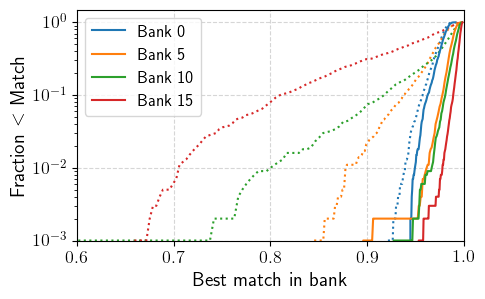

In [42]:
fig, ax = plt.subplots()
ax.set_yscale('log')
a, b = np.histogram(effectualness_0[:,1],bins=100)
ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='C0',ls='dotted')
a, b = np.histogram(effectualness_5[:,1],bins=100)
plt.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='C1',ls='dotted')
a, b = np.histogram(effectualness_10[:,1],bins=100)
plt.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='C2',ls='dotted')
a, b = np.histogram(effectualness_15[:,1],bins=100)
plt.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='C3',ls='dotted')
a, b = np.histogram(effectualness_0[:,2],bins=100)
plt.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='C0', label='Bank 0')
a, b = np.histogram(effectualness_5[:,2],bins=100)
plt.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='C1', label='Bank 5')
a, b = np.histogram(effectualness_10[:,2],bins=100)
plt.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='C2', label='Bank 10')
a, b = np.histogram(effectualness_15[:,2],bins=100)
plt.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='C3', label='Bank 15')
# ax2 = ax.twinx()
# ax2.get_yaxis().set_visible(False)
# ax2.plot(np.NaN, np.NaN, ls='--', c='k')
# ax2.plot(np.NaN, np.NaN, c='k')
# ax2.legend(['22 only banks','22+HM banks'],loc=3,fontsize=10, bbox_to_anchor=(0.29, 0.76))
plt.yscale('log'); ax.set_xlabel('Best match in bank', size=14); ax.set_ylabel('Fraction $<$ Match',size=14); 
plt.xlim(left=0.6,right=1.); ax.set_ylim(1e-3,1.5); ax.legend(loc=2,fontsize=12);
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

### Extra: Debugging effectualness code

In [ ]:
# This section is optional, if you get weird results in the effectualness plots,
# here are some tests to do some first checks

In [28]:
# Easy check: input a calpha waveform from the bank 
# and check if the code recovers it completely

h = bank.gen_wfs_fd_from_calpha(calpha=[0.5,0],log=False, fs_out=bank.fs_fft, orthogonalize=False)
lwfs = np.log(np.abs(h[0])) + 1j * np.unwrap(np.angle(h[0]))
h = h[0] + 0.6*h[1] + 0.3*h[2]
lwfs22 = np.log(np.abs(h)) + 1j * np.unwrap(np.angle(h))

bank.test_effectualness(wfs_fd=np.array([lwfs]), HM=True, do_optimization=True, delta_calpha=delta_calpha,
                        wfs_22_fd=np.array([lwfs22]))

/tmp/ipykernel_862394/2440867235.py:4: RuntimeWarning: divide by zero encountered in log
  lwfs = np.log(np.abs(h[0])) + 1j * np.unwrap(np.angle(h[0]))
/tmp/ipykernel_862394/2440867235.py:6: RuntimeWarning: divide by zero encountered in log
  lwfs = np.log(np.abs(h)) + 1j * np.unwrap(np.angle(h))


array([[0.99523259, 0.99523259]])

In [29]:
# If there is trouble with conditioning,
# One can use the following alternative way of converting 
# wf from fd to td (without any conditioning applied)

fs_fft = bank.fs_fft

def td_convert(wf_fd):
    return(utils.IRFFT(wf_fd*(2 * (len(fs_fft) - 1)) * np.sqrt(2 / (2 * fs_fft[-1]) / bank.asdf(fs_fft)**2),
                               n=(2 * (len(fs_fft) - 1)), axis=-1))

In [30]:
# Check loss due to frequency cutoff in fs
fs = bank.fs_unwrap
fs = np.unique(np.append(fs,[fs*3/2,fs*4/2]))
p = pars_test_bank[10]; par_dic['iota'] = InclArr[10]
par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
h2 = tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomHM', [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3)])[0]
_ = np.log(np.abs(h2)) + 1j * np.unwrap(np.angle(h2))
lwfs2 = tg.upsample_lwfs(_, fs, bank.fs_fft)
h2 = np.exp(lwfs2);

mask = bank.fs_fft>=15
h = tg.compute_hplus_hcross(bank.fs_fft, par_dic, 'IMRPhenomHM', [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3)])[0]
h[~mask] = 0 # h[0] = 0
print(np.sum(h*np.conj(h2)/bank.asdf(bank.fs_fft)**2)/ np.sqrt(np.sum(h*np.conj(h)/bank.asdf(bank.fs_fft)**2) * np.sum(h2*np.conj(h2)/bank.asdf(bank.fs_fft)**2)))

wf_whitened_fd = h2 * bank.wt_filter_fd * np.sqrt(2 * bank.dt)
support, shift, normfac = bank.get_waveform_conditioning(bank.fftsize, bank.dt, wf_whitened_fd)
td2 = bank.gen_wfs_td_from_fd(h2, whiten=True, highpass=True, truncate=True,fs_in=bank.fs_fft, support=support, shift=shift, target_snr=1)

wf_whitened_fd = h * bank.wt_filter_fd * np.sqrt(2 * bank.dt)
support, shift, normfac = bank.get_waveform_conditioning(bank.fftsize, bank.dt, wf_whitened_fd)
td = bank.gen_wfs_td_from_fd(h, whiten=True, highpass=True, truncate=True,fs_in=bank.fs_fft, support=support, shift=shift, target_snr=1)
print(utils.match(td,td2))

td = bank.gen_wfs_td_from_fd(h, whiten=True, highpass=True, truncate=True,fs_in=bank.fs_fft, support=support, shift=shift, target_snr=1)
# td2 = bank.gen_wfs_td_from_fd(h, whiten=True, highpass=False, truncate=False,fs_in=bank.fs_fft, support=support, shift=shift, target_snr=1)
td2 = td_convert(h)
utils.match(td,td2)

/data/jayw/IAS/GW/gw_detection_ias/template_bank_generator_HM.py:234: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))


(0.9995733875769118+1.3730769482166992e-05j)
0.9987340493962544


0.9977658654088193

In [26]:
h = bank.gen_wfs_fd_from_calpha(calpha=coeff_grid[3], fs_out=bank.fs_fft, log=False)[0]

wf_whitened_fd = h * bank.wt_filter_fd * np.sqrt(2 * bank.dt)
td = bank.gen_wfs_td_from_fd(h, whiten=True, highpass=True, truncate=True, fs_in=bank.fs_fft, target_snr=1)
td2 = td_convert(h)
utils.match(td,td2)

/data/jayw/IAS/GW/gw_detection_ias/utils.py:965: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.interp(np.log(f_axis), np.log(freq), np.log(asd),


0.9983190812000693

# 4. Old codes and paper plots

In [ ]:
# This section is not properly maintained and
# could be ignored if you just want to run the pipeline.
# This section contains various code snippets that were used
# to make the plots in arXiv:2310.15233 

In [15]:
import matplotlib as mpl
# Function for changing settings while making plots for paper
# useful as usetex settings are sometimes expensive
def mpl_settings(settings):
    if (settings=='default'):
        mpl.rc('text', usetex=False)
        mpl.rcParams['legend.fontsize'] = 'medium'
        plt.rcParams["xtick.labelsize"] = 'medium'
        plt.rcParams["ytick.labelsize"] = 'medium'
        plt.rcParams['axes.labelsize'] = 'medium'
        plt.rcParams['axes.titlesize']='large'
        plt.rcParams["figure.figsize"] = [5.0, 3.0]
        plt.rcParams["legend.fontsize"]='medium'
    elif(settings=='paper'):
        mpl.rc('text', usetex=True)
        plt.rcParams["xtick.labelsize"] = 13; plt.rcParams["ytick.labelsize"] = 13
        plt.rcParams['axes.labelsize']=15
        plt.rcParams['axes.titlesize']=15
        plt.rcParams["legend.fontsize"]=17
        plt.rcParams["figure.titlesize"]=17

In [16]:
mpl_settings('paper')

### Paper plots

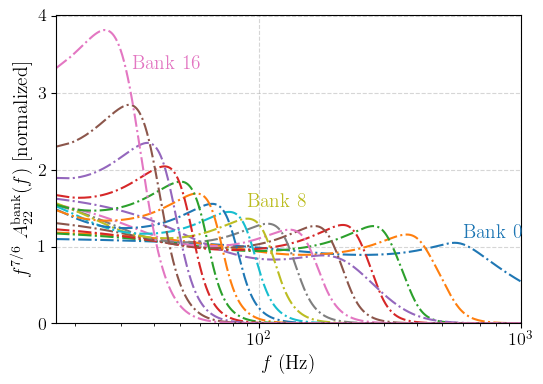

In [29]:
for Af in Af_kmeans_22:
    plt.plot(f_amp,Af,'-.')
plt.xlabel('$f$ (Hz)', usetex=True, size=14); plt.ylabel(' $f^{7/6}\ A^\mathrm{bank}_{22}(f) $   [normalized]', usetex=True, size=14)
plt.xscale('log'); plt.text(600, 1.1,'Bank 0',color='C0')
plt.text(90, 1.5,'Bank 8',color='C8')
plt.text(33, 3.3,'Bank 16',color='C16');
plt.ylim(bottom=0); plt.xlim(left=f_amp[0],right=f_amp[-1])
plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

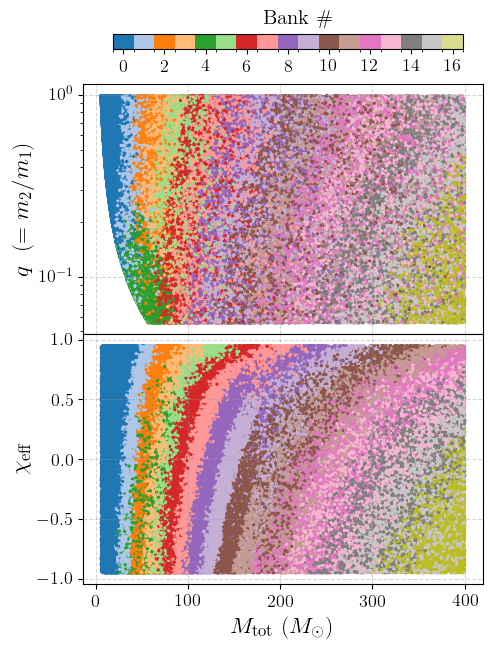

In [30]:
fig = plt.figure(num=None, figsize=(10, 5))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

ax1 = fig.add_axes([0.05, 0.5, 0.4, 0.5]); #, xlim=(6e13,1.1e15)
ax2 = fig.add_axes([0.05, 0, 0.4, 0.5]); #, xlim=(6e13,1.1e15),ylim=(-0.22,0.22)
cbaxes = fig.add_axes([0.08, 1.07, 0.35, 0.03]); cbaxes.grid(False)

ax1.set_yscale('log')
colors =  plt.cm.tab20( np.arange(17,dtype=int) )
im = ax1.scatter(Mrandom,np.exp(lnqrandom),c=colors[bank_ids],s=2); #ax1.yscale('log')
ax1.set_ylabel('$q\ \ (=m_2/m_1)$',size=17,usetex=True);
cmap = plt.cm.tab20; bounds = np.arange(-0.5,17)
norm = mpl.colors.BoundaryNorm(bounds, 18)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="horizontal", cax=cbaxes);
# cbar = plt.colorbar(im, orientation="horizontal", cax=cbaxes); #cbar.set_label('Bank', size=15,usetex=True)

ticks = np.arange(0, 17,2)  # Define the integer ticks
tick_locator = mpl.ticker.FixedLocator(ticks)
cbar.locator = tick_locator
cbar.update_ticks()

ax2.scatter(Mrandom,chieffrandom,s=2,c=colors[bank_ids]); #ax1.yscale('log')
ax2.set_xlabel('$M_\mathrm{tot}\ (M_\odot)$',size=17,usetex=True); ax2.set_ylabel('$\chi_\mathrm{eff}$',size=17,usetex=True)
fig.text(0.23, 1.12, "Bank $\#$",fontsize=15, usetex=True);
plt.savefig(plotdir+'trash.png', bbox_inches='tight', dpi=150);

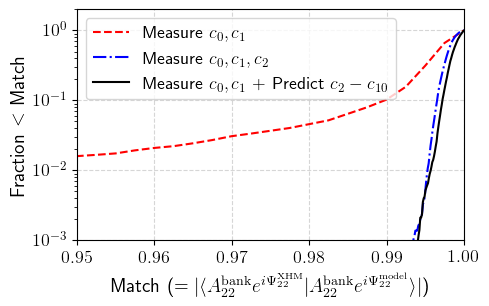

In [72]:
# Figure for paper (from the section 'Making sub-banks')
mpl_settings('paper')
fig, ax = plt.subplots()
ax.set_yscale('log')
a, b = np.histogram(cos_exp_f0[0],bins=100)
ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='red',ls='--', label='Measure $c_0, c_1$')
a, b = np.histogram(cos_exp_f1[0],bins=100)
ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='blue',ls='-.', label='Measure $c_0, c_1, c_2$')
a, b = np.histogram(cos_exp_f2[0],bins=100)
ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='black', label='Measure $c_0, c_1$ + Predict $c_2 - c_{10}$')
plt.yscale('log'); plt.ylim(0.001,2); plt.xlim(0.95,1.); plt.legend(loc=2, fontsize=13)
plt.xlabel('Match    ' r'($=|\langle A^\mathrm{bank}_{22} e^{i\Psi^\mathrm{XHM}_{22}}| A^\mathrm{bank}_{22} e^{i\Psi^\mathrm{model}_{22}} \rangle|$)', usetex=True, size=14); 
plt.ylabel('Fraction $<$ Match', usetex=True, size=14);
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');
mpl_settings('default')

In [ ]:
# Making paper and talk plots

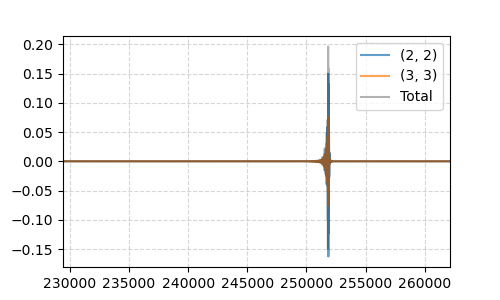

In [ ]:
#del
%matplotlib widget
# Bank - 7
fig, ax = plt.subplots()
ax.plot(wf[0], alpha=0.7, label='(2, 2)')
ax.plot(wf[1]*0.5, alpha=0.7, label='(3, 3)')
# ax.plot(wf[2]*0.35, alpha=0.6, label='(4, 4)')
ax.plot(wf[0]+wf[1]*0.5,alpha=0.3, label='Total', color='k')
ax.set_xlim((bank.fftsize - bank.support_whitened_wf, bank.fftsize))
ax.legend();

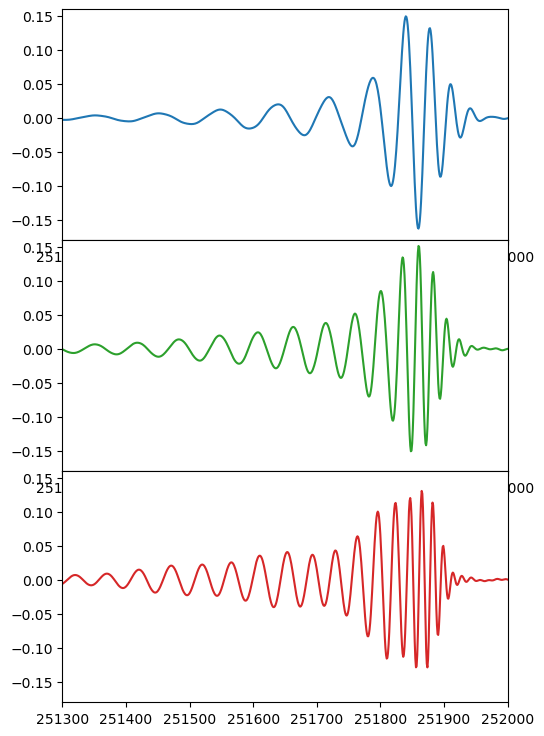

In [112]:
fig = plt.figure(num=None, figsize=(5.3, 7))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

ax1 = fig.add_axes([0.15, 0.91, 0.84, 0.33], xlim=(251300,252000),ylim=(-0.18,0.16));
ax2 = fig.add_axes([0.15, 0.58, 0.84, 0.33], xlim=(251300,252000),ylim=(-0.18,0.16)); 
ax3 = fig.add_axes([0.15, 0.25, 0.84, 0.33], xlim=(251300,252000),ylim=(-0.18,0.16)); 

ax1.plot(wf[0], label='(2, 2)')
ax2.plot(wf[1], label='(2, 2)',color='C2')
ax3.plot(wf[2], label='(2, 2)',color='C3')
plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

In [5]:
# Code for making Fig.2 of the paper
# How much loss on ignoring l neq m multipoles or HM in general

In [13]:
nwfs = 1000000

In [14]:
alpha=1/3

lnqrandom=np.random.uniform(np.log(1/18),np.log(0.99),nwfs)
chieffrandom=np.random.uniform(-0.95,0.95,nwfs)
cumchidiffrandom=np.random.uniform(0,1,nwfs)

## Put similar number in each bank

Mrandom=np.random.uniform(6**(1-alpha),400**(1-alpha),int(nwfs/2))
Mrandom=Mrandom**(1/(1-alpha))

## Add so I have better distribution in phase scale

_=np.random.uniform(np.log(6),np.log(400),int(nwfs/2))
_=np.exp(_)
Mrandom=np.append(Mrandom,_)

input_pars = par_transform(Mrandom,lnqrandom,chieffrandom,cumchidiffrandom)

In [23]:
def overlap(h1_dets, h2_dets,absolute=True):
    overlaps = np.sum(h1_dets * np.conj(h2_dets) * weights, axis=-1)
    if absolute: return abs(overlaps)
    else: return (overlaps)

# Taken from template bank generator
def orthogonalize_wfs(wfs, weights):
        
    full_CovMat = np.zeros((3,3),dtype = 'complex128')

    for (j,k) in np.array(np.triu_indices(3)).T:
        full_CovMat[j,k] = np.sum( weights* wfs[j]* np.conj(wfs[k]), axis=-1)

    full_CovMat[np.tril_indices(3)] = full_CovMat.T.conj()[np.tril_indices(3)]

    L = np.linalg.cholesky( np.linalg.inv(full_CovMat[::-1,::-1]) )[::-1,::-1]

    wfs = np.dot( L.conj().T, wfs)

    return(wfs, full_CovMat)

def calculate_Z(i ,orthogonalize=True):
    p=input_pars[i]
    pdic_local = copy.deepcopy(par_dic)
    pdic_local['m1'] = p[0]; pdic_local['m2'] = p[1]; pdic_local['s1z'] = p[2];
    pdic_local['s2z'] = p[3]; pdic_local['iota']=incl_array[i]
    h1 = np.zeros((3,len(f_amp)),dtype='complex128') 
    for i in range(3): 
        h1[i] = tg.compute_hplus_hcross(f_amp, pdic_local, 'IMRPhenomXHM', [(2+i, 2+i), (2+i, -2-i)])[0]/Aref;
        h1[i] /= np.sqrt(overlap(h1[i],h1[i]))
        
    if orthogonalize:
        _ , CovMat= orthogonalize_wfs(wfs=h1, weights=weights)
    else:
        _ = h1.copy()
    href = tg.compute_hplus_hcross(f_amp, pdic_local, 'IMRPhenomXHM',
                [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (2, -2), (2, -1), (3, -3), (3, -2), (4, -4)])[0]/Aref
    norm = overlap(href, href) # older version: norm included both h+ and hx
    href = href/np.sqrt(norm)
    z22 = overlap(href,_[0])
    z33 = overlap(href,_[1])
    z44 = overlap(href,_[2])
    # Separately taking the cosine with the three modes and then adding
    return(np.sqrt(z22**2+ z33**2 +z44**2), np.sqrt(z22**2+ z33**2), z22)

In [24]:
incl_array = np.random.rand(int(3e6))*np.pi/2

# Inclination distribution taken from Eq. (28) of Schutz et al 2011 (1102.5421) 
# divided by max value obtained using the following
# max_P_incl = -minimize_scalar(lambda x: -P_incl(x), bounds=(0, np.pi/2), method='bounded').fun

P_incl = lambda i:  2*0.076*(1+6*np.cos(i)**2+np.cos(i)**4)**1.5 * np.sin(i) / (1.1357)
mask = np.random.rand(len(incl_array)) < P_incl(incl_array)
incl_array = incl_array[mask]

In [25]:
# Overlap with using only a few modes

with mp.Pool(20) as p:
        cosine = p.map(calculate_Z,np.arange(nwfs))
cosine = np.array(cosine)
cosine_22_33_44, cosine_22_33, cosine_22 = cosine.T

# If not using multiprocessing
# for i in range(nwfs):
#     p=input_pars[i]
#     cosine_22[i], cosine[i]=calculate_Z(par_dic)

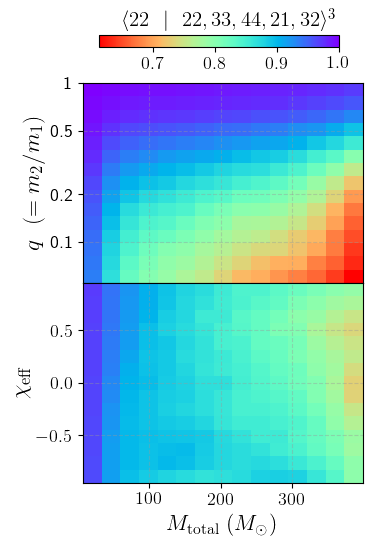

In [44]:
fig = plt.figure(num=None, figsize=(8, 4))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

ax1 = fig.add_axes([0.05, 0.5, 0.35, 0.5]);
ax2 = fig.add_axes([0.05, 0, 0.35, 0.5]);
cax = fig.add_axes([0.07, 1.09, 0.3, 0.03]); cax.grid(False)
# cax = fig.add_axes([0.42, 0.25, 0.012, 0.5]); cax.grid(False)

hist, x_edges, y_edges = np.histogram2d( Mrandom[:nwfs], lnqrandom[:nwfs]/np.log(10), weights=cosine_22**3, bins=(15, 15))
norm, _, _ = np.histogram2d(Mrandom[:nwfs], lnqrandom[:nwfs]/np.log(10), bins=(15, 15))

plot2d = ax1.imshow(np.transpose(hist/norm), extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           origin='lower', cmap='rainbow_r', aspect='auto')
ax1.set_yticks([0,np.log10(0.5),np.log10(0.2),-1], ['1', '0.5', '0.2', '0.1'])
ax1.set_ylabel('$q\ \ (=m_2/m_1)$',size=17);
cbar = plt.colorbar(plot2d, cax=cax, orientation='horizontal')

hist2, x_edges, y_edges = np.histogram2d(chieffrandom[:nwfs], Mrandom[:nwfs], weights=cosine_22**3, bins=(15, 15))
norm2, _, _ = np.histogram2d(chieffrandom[:nwfs],Mrandom[:nwfs], bins=(15, 15))

plot2d_2 = ax2.imshow(hist2/norm2, extent=[y_edges[0], y_edges[-1], x_edges[0], x_edges[-1]],
           origin='lower', cmap='rainbow_r', aspect='auto')

plot2d.set_clim(min(np.amin(hist/norm), np.amin(hist2/norm2)), 1)
plot2d_2.set_clim(min(np.amin(hist/norm), np.amin(hist2/norm2)), 1)
ax2.set_ylabel('$\chi_\mathrm{eff}$',size=17)
fig.text(0.1, 1.14, r'$\langle 22\ \ |\ \ 22,33,44,21,32\rangle^3$',fontsize=15)
# cbar.set_label(r'$\langle 22\, |\, 22,33,44,21,32\rangle$',size=15)
ax2.set_xlabel('$M_\mathrm{total}\ (M_\odot)$',size=16);
plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

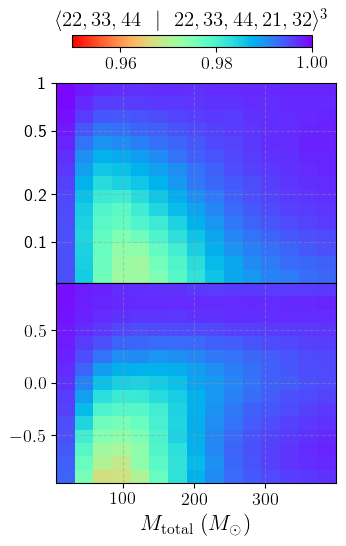

In [43]:
fig = plt.figure(num=None, figsize=(8, 4))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

ax1 = fig.add_axes([0.05, 0.5, 0.35, 0.5]);
ax2 = fig.add_axes([0.05, 0, 0.35, 0.5]);
cax = fig.add_axes([0.07, 1.09, 0.3, 0.03]); cax.grid(False)
# cax = fig.add_axes([0.42, 0.25, 0.012, 0.5]); cax.grid(False)

hist, x_edges, y_edges = np.histogram2d( Mrandom[:nwfs], lnqrandom[:nwfs]/np.log(10),
                                         weights=cosine_22_33_44**3, bins=(15, 15))
norm, _, _ = np.histogram2d(Mrandom[:nwfs], lnqrandom[:nwfs]/np.log(10), bins=(15, 15))

plot2d = ax1.imshow(np.transpose(hist/norm), extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           origin='lower', cmap='rainbow_r', aspect='auto')
ax1.set_yticks([0,np.log10(0.5),np.log10(0.2),-1], ['1', '0.5', '0.2', '0.1'])
# ax1.set_ylabel('$q\ \ (=m_2/m_1)$',size=17);
cbar = plt.colorbar(plot2d, cax=cax, orientation='horizontal')

hist2, x_edges, y_edges = np.histogram2d(chieffrandom[:nwfs], Mrandom[:nwfs],
                                          weights=cosine_22_33_44**3, bins=(15, 15))
norm2, _, _ = np.histogram2d(chieffrandom[:nwfs],Mrandom[:nwfs], bins=(15, 15))

plot2d_2 = ax2.imshow(hist2/norm2, extent=[y_edges[0], y_edges[-1], x_edges[0], x_edges[-1]],
           origin='lower', cmap='rainbow_r', aspect='auto')

plot2d.set_clim(.95, 1)
plot2d_2.set_clim(.95, 1)
# ax2.set_ylabel('$\chi_\mathrm{eff}$',size=17)
fig.text(0.05, 1.14, r'$\langle 22,33,44\ \ |\ \ 22,33,44,21,32\rangle^3$',fontsize=15)
# cbar.set_label(r'$\langle 22\, |\, 22,33,44,21,32\rangle$',size=15)
ax2.set_xlabel('$M_\mathrm{total}\ (M_\odot)$',size=16);
plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

In [ ]:
# For the plot for phase model for the paper
# run after the section 'Higher mode SVDs' for bank 8

In [30]:
ib=8; isb=0
wt=weights_banks[ib]**0.5
dire = os.path.join(tbp.DIR,'BBH_'+str(ib)) 
dire2 = os.path.join(dire,'bank_'+str(isb))
ca22 = np.load(os.path.join(dire2,'coeffs.npy'))

SVD_SubBank=SVD_SubBanks[ib]
Up, sp, Vph, mean_phase = SVD_SubBank[isb]
phases = Up @ np.diag(sp) @ Vph + mean_phase
ca = Up @ np.diag(sp)

ca_grid=ca.copy()
ca_grid[:,ndims_HM:]=0
ca_grid=np.rint(ca_grid*8)/8. # Gridding

if((ib==0 and isb==2) or (ib==0 and isb==3) or (ib==1 and isb==0) or (ib==2 and isb==0)): ndims=3
else: ndims=2
ca22_grid = ca22.copy(); ca22_grid = np.rint(ca22_grid*8)/8.; ca22_grid[:,ndims:]=0

ind = np.ones(len(ca)).astype(bool); ind[int(len(ca)/2):]*=False
ca_grid = ca_grid[ind]; phases = phases[ind]; ca22_grid = ca22_grid[ind]
rg_rf.fit(ca22[:, :ndims][~ind],ca[:,:ndims_HM][~ind])
ca_grid[:,:ndims_HM]=rg_rf.predict(ca22_grid[:,:ndims])
phases_RF = ca_grid @ Vph + mean_phase

In [31]:
mask=bank_ids==ib; mask*=subbank_ids==isb

In [95]:
ib=8; isb=0
dire = os.path.join(tbp.DIR,'BBH_'+str(ib))    
dire2 = os.path.join(dire,'bank_'+str(isb))
ca22 = np.load(os.path.join(dire2,'coeffs.npy'))[:,:ndims]#[~mask_outliers]

ca  = ca_SubBanks[isb]; Vph = Vph_SubBanks[isb]; phases = phases_SubBanks[isb]

# Training a RF:
ind=np.random.choice([0, 1], size=(len(ca),), p=[1./2, 1./2]).astype('bool'); 
rg_rf.fit(ca22[~ind],ca[~ind])
ca22_grid = np.rint(ca22*8)/8.;
ca_grid_pred = rg_rf.predict(ca22_grid[ind])

constant = ca[:,:2]; ca = ca[:,2:]; 
mean_phase = Vph[:2,:]; Vph = Vph[2:,:]
mode=0
phases_33_pred = ca_grid_pred[:,2+mode*ndims_HM:2+(mode+1)*ndims_HM] @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:] + mean_phase[mode]
mode=1
phases_44_pred = ca_grid_pred[:,2+mode*ndims_HM:2+(mode+1)*ndims_HM] @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:] + mean_phase[mode]

In [155]:
np.argmin(np.abs(f_phases_banks[ib]*3/2-100)), np.argmin(np.abs(f_phases_banks[ib]*4/2-100))

(478, 291)

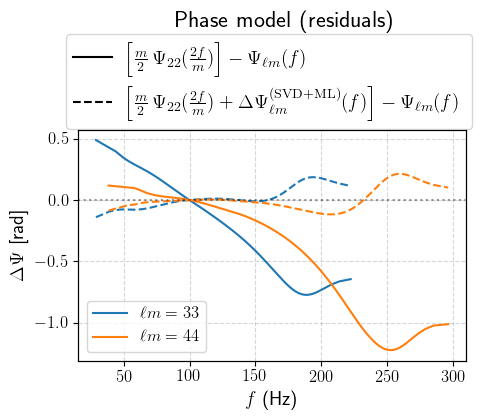

In [161]:
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(figsize=(5,3))
plt.yticks(size=12); plt.xticks(size=12)
mask=bank_ids==ib; mask*=subbank_ids==isb
plt.plot(np.NaN, np.NaN, c='k')
plt.plot(np.NaN, np.NaN, c='k',ls='--')
index=60
_=-phases_SubBanks[isb][ind][index,0]/wt; plt.plot(f_phases_banks[ib]*3/2,_-_[478])
_=-(phases_33_pred[index]-phases_SubBanks[isb][ind][index,0])/wt;plt.plot(f_phases_banks[ib]*3/2,_-_[478], color='C0', ls='--')
_=-phases_SubBanks[isb][ind][index,1]/wt;plt.plot(f_phases_banks[ib]*4/2,_-_[291])
_=-(phases_44_pred[index]-phases_SubBanks[isb][ind][index,1])/wt; plt.plot(f_phases_banks[ib]*4/2,_-_[291], color='C1', ls='--')
plt.axhline(y=0,ls='dotted',c='k',alpha=0.4)
ax.legend([r'$\left[\frac{m}{2}\, \Psi_{22} (\frac{2 f}{m})\right] - \Psi_{\ell m}(f)$',
r'$\left[\frac{m}{2}\, \Psi_{22} (\frac{2 f}{m}) + \Delta \Psi_{\ell m}^\mathrm{(SVD+ML)}(f)\right] - \Psi_{\ell m}(f)$'],
          fontsize=14,loc=4, bbox_to_anchor=(1.04, .96))
ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)
ax2.plot(np.NaN, np.NaN, c='C0')
ax2.plot(np.NaN, np.NaN, c='C1')
ax2.legend(['$\ell m=33$','$\ell m=44$'],loc=3,fontsize=12)
ax.set_xlabel('$f$ (Hz)', fontsize=14); ax.set_ylabel('$\Delta \Psi$  [rad]', fontsize=14);
plt.rcParams['text.usetex'] = False
fig.text(0.32, 1.22,'Phase model (residuals)',usetex=True,size=17);
plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

In [162]:
mask=bank_ids==ib; mask*=subbank_ids==isb
np.arange(len(bank_ids))[mask][ind][index]

4756

In [89]:
f_plot = np.geomspace(10,1000,2000)

In [90]:
approximant = 'IMRPhenomXHM'

# This cell is used for generating the amplitudes
# not needed if you want to load the amplitudes from the cell below

def amps_HM(fs , p , hm=True):
    par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
    
    if hm is False:
        amp = np.abs(tg.compute_hplus_hcross(fs, par_dic, approximant, [(2, 2)])[1])
        
    else:
        amp = np.zeros((3,len(fs)))
        amp[0] = np.abs(tg.compute_hplus_hcross(fs, par_dic, approximant, [(2, 2)])[1])
        amp[1] = np.abs(tg.compute_hplus_hcross(fs, par_dic, approximant, [(3, 3)])[1])
        amp[2] = np.abs(tg.compute_hplus_hcross(fs, par_dic, approximant, [(4, 4)])[1])
        # can use Phenom HM if XHM is not working
        
    return(amp)

In [91]:
iota = np.pi/3
par_dic = {
    'd_luminosity': 100.0,
    'f_ref': 50.0,
    'iota': iota,
    'l1': 0.0,
    'l2': 0.0,
    'm1': 50,
    'm2': 3.4,
    's1x': 0.000,
    's1y': 0.0,
    's1z': -0.24,
    's2x': 0.000,
    's2y': 0.0,
    's2z': -0.2,
    'phi_ref': 0.0}

In [92]:
it=4756; print(input_pars[it])
amps = amps_HM(f_plot, input_pars[it])
m1, m2 = input_pars[it][:2]
q = m2/m1

[87.47580321 20.08726513 -0.4554494  -0.71548803  0.          0.        ]


In [93]:
analytic_33 = amps_HM(f_plot*2/3, input_pars[it])[0] * np.sqrt(27/32)*(1-q)/(1+q)*np.sin(iota)\
                *(2*np.pi*(m1+m2)*f_plot/3*1.989e33*5.62e23*6.58e-25/(1.22e19**2))**(1/3) 

analytic_44 = amps_HM(f_plot/2, input_pars[it])[0] * np.sqrt(8/9)*(1 - (3*q/(1+q)**2))*(np.sin(iota)**2)\
                *(2*np.pi*(m1+m2)*f_plot/4*1.989e33*5.62e23*6.58e-25/(1.22e19**2))**(2/3)

/tmp/ipykernel_2713844/418399503.py:17: RuntimeWarning: divide by zero encountered in divide
  ax2.semilogx(f_plot,amps[1]/analytic_33,color='C1',label='$A_{33}(f)/[c\,f^{1/3}\,A_{22}(2f/3)]$')


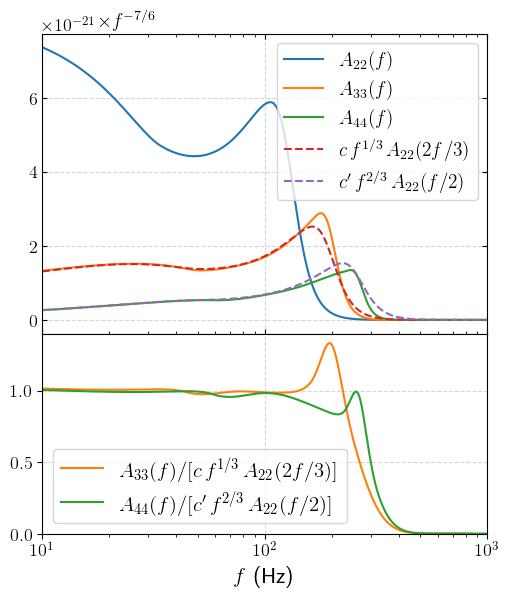

In [94]:
analytic_33*=.95
analytic_44*=.94
fig = plt.figure(num=None, figsize=(5.3, 5))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

ax1 = fig.add_axes([0.15, 0.4, 0.84, 0.6], xlim=(8,1100));
ax2 = fig.add_axes([0.15, 0.0, 0.84, 0.4], xlim=(8,1100));
ax1.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelbottom=0)

ax1.semilogx(f_plot,amps[0]*f_plot**(7/6),label='$A_{22}(f)$')
ax1.semilogx(f_plot,amps[1]*f_plot**(7/6),label='$A_{33}(f)$')
ax1.semilogx(f_plot,amps[2]*f_plot**(7/6),label='$A_{44}(f)$')
ax1.semilogx(f_plot,analytic_33*f_plot**(7/6),ls='--',label='$c\,f^{1/3}\,A_{22}(2f/3)$')
ax1.semilogx(f_plot,analytic_44*f_plot**(7/6),ls='--', label='$c^\prime\,f^{2/3}\,A_{22}(f/2)$')
ax1.legend(fontsize=14); ax1.set_xlim(left=10,right=1000); #ax1.set_ylim(bottom=0)

ax2.semilogx(f_plot,amps[1]/analytic_33,color='C1',label='$A_{33}(f)/[c\,f^{1/3}\,A_{22}(2f/3)]$')
ax2.semilogx(f_plot,amps[2]/analytic_44,color='C2',label='$A_{44}(f)/[c^\prime\,f^{2/3}\,A_{22}(f/2)]$')
ax2.legend(fontsize=15,loc=3); ax2.set_xlim(left=10,right=1000); ax2.set_ylim(bottom=0)
plt.xlabel('$f$ (Hz)', fontsize=16)

ax1.grid(which='major', color='#999999', linestyle='--',alpha=0.4)
ax2.grid(which='major', color='#999999', linestyle='--',alpha=0.4)
plt.text(18, 3.545, r'$\times f^{-7/6}$', fontsize=14)
plt.savefig(plotdir+'trash.pdf', bbox_inches='tight')

In [46]:
# Checking the cosines

ib = 8 # id of bank to probe
ndims_HM = 3 # Dimensions of HM phase basis to include
ndims=2 # Number of dimensions used for calpha_22

rg_rf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=2)

wt=weights_banks[ib]**0.5
bins=SubBank_Mchirp_bins[ib]
ca_SubBanks, Vph_SubBanks, phases_SubBanks = SVD_HM_banks(ib)
cos_exp_f0=[]; cos_exp_f1=[]; cos_exp_f2=[]

# Loading 22 calphas
dire = os.path.join(tbp.DIR,'BBH_'+str(ib))

for isb in range(len(bins)):
    
    dire2 = os.path.join(dire,'bank_'+str(isb))
    ca22 = np.load(os.path.join(dire2,'coeffs.npy'))[:,:ndims]#[~mask_outliers]
    
    ca  = ca_SubBanks[isb]; Vph = Vph_SubBanks[isb]; phases = phases_SubBanks[isb]
    
    # Training a RF:
    ind=np.random.choice([0, 1], size=(len(ca),), p=[1./2, 1./2]).astype('bool');
    
    rg_rf.fit(ca22[~ind],ca[~ind])
    ca22_grid = np.rint(ca22*8)/8.;
    ca_grid_pred = rg_rf.predict(ca22_grid[ind])
    
    ca = ca[:,2:]
    
    rg_rf.fit(np.c_[ca22[~ind], ca[~ind,0]],ca[~ind,1:3])
    ca22_grid = np.rint(np.c_[ca22,ca[:,0]]*8)/8.;
    ca_33_grid_pred = np.c_[np.rint(ca[ind,0]*8)/8.,rg_rf.predict(ca22_grid[ind])]
    rg_rf.fit(np.c_[ca22[~ind], ca[~ind,0]],ca[~ind,3:])
    ca_44_grid_pred = rg_rf.predict(ca22_grid[ind])
    mean_phase = Vph[:2,:]; Vph = Vph[2:,:]

    for mode in range(2):
        ca_grid=np.zeros_like(ca[:,mode*ndims_HM:(mode+1)*ndims_HM])
        phases_f = ca_grid @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:] 
        cos_exp_f0.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases[:,mode,:]/wt)*wt))))
        
        phases_f= ca_grid_pred[:,2+mode*ndims_HM:2+(mode+1)*ndims_HM] @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:] + mean_phase[mode]
        cos_exp_f1.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases[ind,mode,:]/wt)*wt))))
        
        if mode==0:
            phases_f= ca_33_grid_pred @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:] + mean_phase[mode]
        else:
            phases_f= ca_44_grid_pred @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:] + mean_phase[mode]
        cos_exp_f2.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases[ind,mode,:]/wt)*wt))))

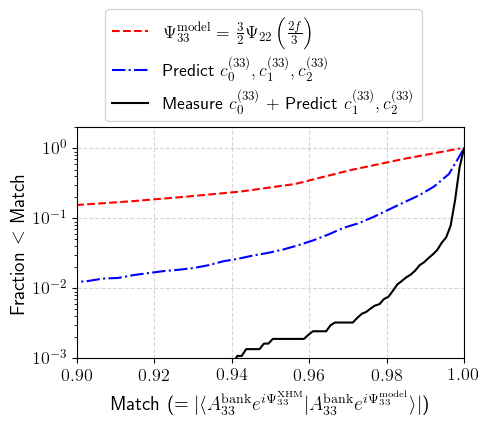

In [58]:
# Figure for paper (from the section 'Making sub-banks')
fig, ax = plt.subplots()
ax.set_yscale('log')
a, b = np.histogram(cos_exp_f0[0],bins=100)
ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='red',ls='--', label=r'$\Psi^\mathrm{model}_{33} =  \frac{3}{2} \Psi_{22}\left(\frac{2f}{3}\right)$')
a, b = np.histogram(cos_exp_f1[0],bins=100)
ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='blue',ls='-.', label='Predict $c^{(33)}_0, c^{(33)}_1, c^{(33)}_2$')
a, b = np.histogram(cos_exp_f2[0],bins=100)
ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='black', label='Measure $c^{(33)}_0$ + Predict $c^{(33)}_1, c^{(33)}_2$')
plt.yscale('log'); plt.ylim(0.001,2); plt.xlim(0.9,1.); plt.legend(loc=2,bbox_to_anchor=(0.05, 1.55),fontsize=13)
plt.xlabel('Match    ' r'($=|\langle A^\mathrm{bank}_{33} e^{i\Psi^\mathrm{XHM}_{33}}| A^\mathrm{bank}_{33} e^{i\Psi^\mathrm{model}_{33}} \rangle|$)', usetex=True, size=14); 
plt.ylabel('Fraction $<$ Match', usetex=True, size=14);
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

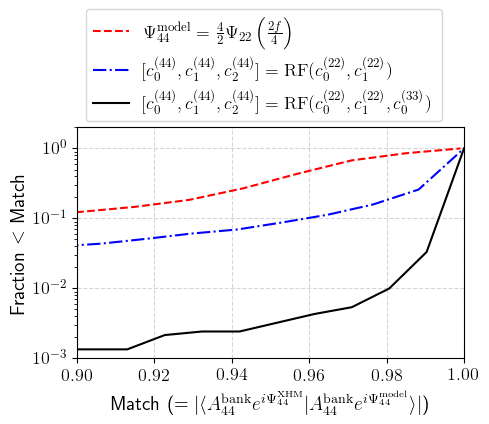

In [57]:
# Figure for paper (from the section 'Making sub-banks')
fig, ax = plt.subplots()
ax.set_yscale('log')
a, b = np.histogram(cos_exp_f0[2],bins=100)
ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='red',ls='--', label=r'$\Psi^\mathrm{model}_{44} =  \frac{4}{2} \Psi_{22}\left(\frac{2f}{4}\right)$')
a, b = np.histogram(cos_exp_f1[2],bins=100)
ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='blue',ls='-.', label='$[c^{(44)}_0, c^{(44)}_1, c^{(44)}_2]=\mathrm{RF}(c^{(22)}_0, c^{(22)}_1)$')
a, b = np.histogram(cos_exp_f2[2],bins=100)
ax.plot(b,np.append(0,np.cumsum(a)/np.sum(a)), color='black', label='$[c^{(44)}_0, c^{(44)}_1, c^{(44)}_2]=\mathrm{RF}(c^{(22)}_0, c^{(22)}_1, c^{(33)}_0)$')
plt.yscale('log'); plt.ylim(0.001,2); plt.xlim(0.9,1.); plt.legend(loc=2,bbox_to_anchor=(0.0, 1.55),fontsize=13)
plt.xlabel('Match    ' r'($=|\langle A^\mathrm{bank}_{44} e^{i\Psi^\mathrm{XHM}_{44}}| A^\mathrm{bank}_{44} e^{i\Psi^\mathrm{model}_{44}} \rangle|$)', usetex=True, size=14);
plt.ylabel('Fraction $<$ Match', usetex=True, size=14);
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

In [15]:
f_plot = np.geomspace(10,1000,1000)
par_dic['d_luminosity']=6780
wf = amps_HM(f_plot, [300,50,0.9,0.9])
wf2 = amps_HM(f_plot, [300,50,-0.82,-0])
inverse_transform([300,50,-0.82,-0])

[-0.7028571428571427, 0.5]

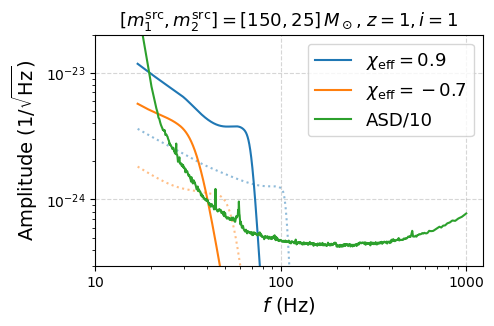

In [132]:
plt.loglog(f_amp, wf[0], label='$\chi_\mathrm{eff} = 0.9$')
plt.loglog(f_amp, wf[1], color='C0',alpha=0.5, ls='dotted')
plt.loglog(f_amp, wf2[0], label='$\chi_\mathrm{eff} = -0.7$')
plt.loglog(f_amp, wf2[1], color='C1',alpha=0.5, ls='dotted')
plt.loglog(f_amp, tg.DEFAULT_ASDF(f_amp)/10, label='ASD/10')
plt.ylim(top=2e-23, bottom=3e-25)
plt.xlim(left=10); plt.legend(fontsize=13)
plt.xlabel('$f$ (Hz)', size=14); plt.ylabel('Amplitude ($1/\sqrt{\mathrm{Hz}}$)',size=14); 
plt.title('$[m^\mathrm{src}_1, m^\mathrm{src}_2] = [150, 25]\, M_\odot$, $z = 1, i=1$', size=13);
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

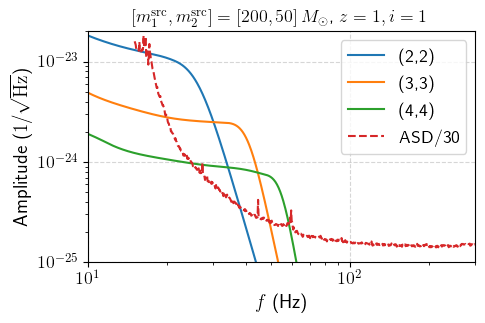

In [22]:
wf2 = amps_HM(f_plot, [400,100,-0.82,-0])
plt.loglog(f_plot, wf2[0], label='(2,2)')
plt.loglog(f_plot, wf2[1], label='(3,3)')
plt.loglog(f_plot, wf2[2], label='(4,4)')
# plt.loglog(trigObj.freq_axis, np.sqrt(trigObj.psd)/50, label='ASD/10')
plt.loglog(f_plot, tg.DEFAULT_ASDF(f_plot)/30, label='ASD/30', ls='--')
plt.ylim(top=2e-23, bottom=1e-25)
plt.xlim(left=10, right=300); plt.legend(fontsize=13)
plt.xlabel('$f$ (Hz)', size=14); plt.ylabel('Amplitude ($1/\sqrt{\mathrm{Hz}}$)',size=14); 
plt.title('$[m^\mathrm{src}_1, m^\mathrm{src}_2] = [200, 50]\, M_\odot$, $z = 1, i=1$', size=13);
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

In [ ]:
# Ignore this cell, we just calculate here the improvement due to RF in num of templates after the banks
# have been saved

# old_templates = 0; RF_templates = 0
# for ib in range(17):
#     for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
#         bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,f'BBH_{ib}',f'bank_{isb}','metadata.json'))
#         RF_templates += bank.ntemplates(delta_calpha=tbp.delta_calpha[f'BBH_{ib}']/4, fudge=tbp.fudge[f'BBH_{ib}'])
#         ndims=3
#         bank.bounds = np.c_[np.min(bank.coeffs[:, :ndims], axis=0),
#                                     np.mean(bank.coeffs[:, :ndims], axis=0),
#                                     np.max(bank.coeffs[:, :ndims], axis=0)]
#         old_templates += bank.ntemplates(delta_calpha=tbp.delta_calpha[f'BBH_{ib}']/4, fudge=tbp.fudge[f'BBH_{ib}'])
# print(old_templates, RF_templates)

### Extra module: Testing effectualness of banks to precession wfs

In [ ]:
# Reloading the sub-bank, if needed
reload(tg)

ib=13 # Bank number
isb=0 # Sub-bank number
delta_calpha = tbp.delta_calpha[f'BBH_{ib}']

bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
bank.set_waveform_conditioning(2**18, 1/2048)

# Finding the pars_test corresponding to the particular sub-bank 

_ = Mchirp_test[bank_ids_test==ib]
mask2 = _<=SubBank_Mchirp_bins[f'BBH_{ib}'][isb][1]; mask2 *= _>SubBank_Mchirp_bins[f'BBH_{ib}'][isb][0]
pars_test_bank = pars_test[bank_ids_test==ib][mask2]
mask2 = (pars_test_bank[:,1]/pars_test_bank[:,0] > 0.1)
pars_test_bank = pars_test_bank[mask2]

In [ ]:
par_dic = {
    'd_luminosity': 1.0,
    'f_ref': 50.0,
    'iota': 1.0,
    'l1': 0.0,
    'l2': 0.0,
    'm1': 50,
    'm2': 3.4,
    's1x': 0.0,
    's1y': 0.0,
    's1z': -0.24,
    's2x': 0.0,
    's2y': 0.0,
    's2z': -0.2,
    'phi_ref': 0.0}

# Splitting the wfs into chunks to use less memory per core
nwfs_chunk = 2 # number of wfs in a chunk

def calc_effectualness(ichunk, compare_with_22only=True, search_full_bank=False):
    '''
    :param ichunk: Index of the wf chunk
    :param compare_with_22only: Boolean flag whether to compare the effectualness with a 22-only bank
    '''
    # First making test waveforms (lwfs = log of wfs)
    fs = bank.fs_unwrap
    lwfs = np.zeros((nwfs_chunk,len(bank.fs_fft)),dtype='complex128'); # Test wfs: 22 + HM
    lwfs22 = np.zeros((nwfs_chunk,len(fs)),dtype='complex128') # Test wfs: 22
    mask = bank.fs_fft>15
    lwfs[:,~mask] = -np.inf;
    for i in range(nwfs_chunk):
        p = pars_test_bank[ichunk*nwfs_chunk+i]
        alpha = np.random.uniform(0., 2.0 * np.pi, size=3)
        par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; 
        par_dic['s1z'] = p[2]; par_dic['s1x'] = 0
        par_dic['s2z'] = p[3]; par_dic['s2x'] = 0;
        par_dic['iota'] = InclArr[ichunk*nwfs_chunk+i]
        h = tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
        lwfs22[i] = np.log(np.abs(h)) + 1j * np.unwrap(np.angle(h))

        par_dic['s1z'] = p[2]*np.cos(alpha[0]); par_dic['s1x'] = p[2]*np.sin(alpha[0]);
        par_dic['s2z'] = p[3]*np.cos(alpha[1]); par_dic['s2x'] = p[3]*np.sin(alpha[1]);
        h = tg.compute_hplus_hcross(bank.fs_fft[mask], par_dic, 'IMRPhenomXPHM',
                        [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)])
        h = np.cos(alpha[2]) * h[0] + np.sin(alpha[2]) * h[1]

        lwfs[i,mask] = np.log(np.abs(h)) + 1j * np.unwrap(np.angle(h))
    
    lwfs22 = tg.upsample_lwfs(lwfs22, fs, bank.fs_fft)
    
    # Calculating effectualness of the wfs
    if compare_with_22only:
        return (# Test wfs: 22, Bank: 22
                np.c_[bank.test_effectualness(wfs_fd=lwfs22, delta_calpha=delta_calpha, HM=False,do_optimization=True)[:,1],
                # Test wfs: 22+HM, Bank: 22
                bank.test_effectualness(wfs_fd=lwfs, delta_calpha=delta_calpha, HM=False,
                                        do_optimization=True, search_full_bank=search_full_bank)[:,1],
                # Test wfs: 22+HM, Bank: 22+HM
                bank.test_effectualness(wfs_fd=lwfs, delta_calpha=delta_calpha, wfs_22_fd=lwfs22, HM=True,
                                        do_optimization=True,search_full_bank=search_full_bank)[:,1]])
    
    else:
        # Test wfs: 22+HM, Bank: 22+HM
        return (bank.test_effectualness(wfs_fd=lwfs, delta_calpha=delta_calpha, wfs_22_fd=lwfs22, HM=True,do_optimization=True)[:,1])

In [ ]:
nwfs = 200
effectualness=[]
for ind, ib in enumerate(range(9, 17)):
    delta_calpha = tbp.delta_calpha[f'BBH_{ib}']

    bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
    bank.set_waveform_conditioning(2**18, 1/2048)
    p = mp.Pool(20)
    effectualness_bank = p.starmap(calc_effectualness, ((i, True, True) for i in np.arange(nwfs//2)))
    p.close(); p.join()
    effectualness.append(np.array(effectualness_bank).reshape(-1,3))

effectualness = np.amax(np.array(effectualness), axis=0)

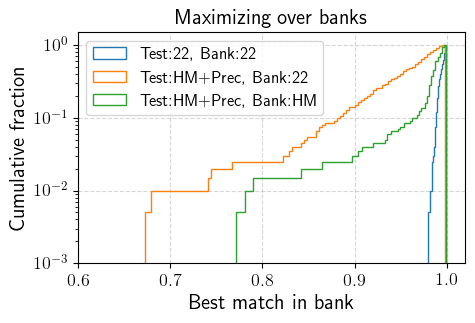

In [ ]:
plt.hist(effectualness[:,0],bins=100,histtype='step',density=True, cumulative=True,label='Test:22, Bank:22')
plt.hist(effectualness[:,1],bins=100,histtype='step',density=True, cumulative=True, label='Test:HM+Prec, Bank:22')
plt.hist(effectualness[:,2],bins=100,histtype='step',density=True, cumulative=True, label='Test:HM+Prec, Bank:HM')
plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.yscale('log'); plt.xlabel('Best match in bank'); plt.ylabel('Cumulative fraction'); 
plt.legend(fontsize=12,loc=2)
plt.xlim(left=0.6,right=1.02); plt.ylim(1e-3,1.5)
plt.title(f'Maximizing over banks');

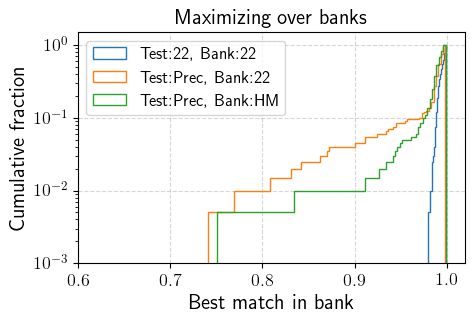

In [ ]:
plt.hist(effectualness[:,0],bins=100,histtype='step',density=True, cumulative=True,label='Test:22, Bank:22')
plt.hist(effectualness[:,1],bins=100,histtype='step',density=True, cumulative=True, label='Test:Prec, Bank:22')
plt.hist(effectualness[:,2],bins=100,histtype='step',density=True, cumulative=True, label='Test:Prec, Bank:HM')
plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.yscale('log'); plt.xlabel('Best match in bank'); plt.ylabel('Cumulative fraction'); 
plt.legend(fontsize=12,loc=2)
plt.xlim(left=0.6,right=1.02); plt.ylim(1e-3,1.5)
plt.title(f'Maximizing over banks');

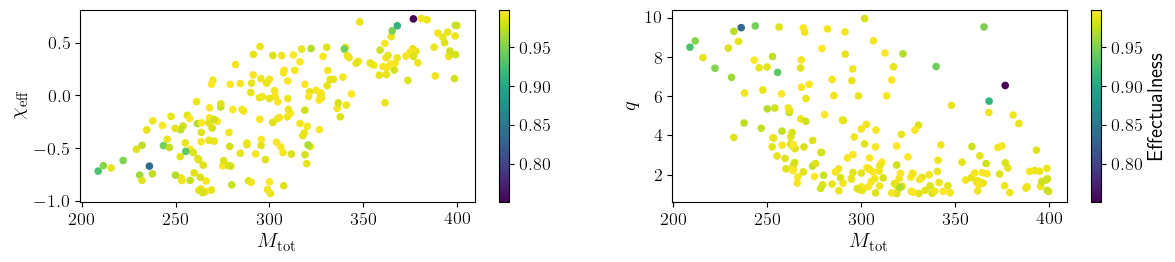

In [ ]:
# Extra code: In case you want to probe where the worst cosine is
mask = effectualness[:,2]<1
chieff_test = np.array([inverse_transform(pars) for pars in pars_test_bank[:nwfs,:4]])[:,0]
plt.figure(figsize=(14,2.5))
plt.subplot(121)
plt.scatter((pars_test_bank[:nwfs,0]+pars_test_bank[:nwfs,1])[mask],chieff_test[mask],
            c=effectualness[:,2][mask],s=20,cmap='viridis'); plt.colorbar()
plt.xlabel('$M_\mathrm{tot}$'); plt.ylabel('$\chi_\mathrm{eff}$')
plt.subplot(122)
plt.scatter((pars_test_bank[:nwfs,0]+pars_test_bank[:nwfs,1])[mask],
            (pars_test_bank[:nwfs,0]/pars_test_bank[:nwfs,1])[mask],
            c=effectualness[:,2][mask],s=20,cmap='viridis'); plt.colorbar(label='Effectualness')
plt.xlabel('$M_\mathrm{tot}$'); plt.ylabel('$q$');

In [ ]:
# The cells below were used for debugging (ignore them)

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline

PsiHM=[]
for i in range(2000,2100):
    Psi=[]
    farr=f_unwrap_banks[bank_ids[i]]
    farr2=f_phases_banks[bank_ids[i]]
    Psi.append(farr2)
    p1=input_pars[i]
    par_dic['m1'] = p1[0]; par_dic['m2'] = p1[1]; par_dic['s1z'] = p1[2]; par_dic['s2z'] = p1[3]
    hp = tg.compute_hplus_hcross(farr, par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
    _0=InterpolatedUnivariateSpline(farr,np.unwrap(np.angle(hp))/2)
    hp = tg.compute_hplus_hcross(farr*3/2, par_dic, 'IMRPhenomXHM', [(3, 3)])[0]
    _1=InterpolatedUnivariateSpline(farr,np.unwrap(np.angle(hp))/3)
    temp=InterpolatedUnivariateSpline(farr,_1(farr)-_0(farr)); temp=temp(farr2)
    Psi.append(temp-np.sum(temp*weights_bank))
    hp = tg.compute_hplus_hcross(farr*4/2, par_dic, 'IMRPhenomXHM', [(4, 4)])[0]
    _2=InterpolatedUnivariateSpline(farr,np.unwrap(np.angle(hp))/4)
    temp=InterpolatedUnivariateSpline(farr,_2(farr)-_0(farr)); temp=temp(farr2)
    Psi.append(temp-np.sum(temp*weights_bank))
    PsiHM.append(Psi)